# Simulations
In this Notebook, I focus on simulations that concern only the individual models. In the next notebook 05_Community I'll merge them into one big model for more sophisticated analyses. These analyses include growth assay on a variety of different media and exploring metabolic niches. \
With the start of my simulations I noticed issues in my models because of the lack of growth or also too high growth rates. That is why this notebook also includes a lot of investigation and curation, especially in the second part of the note book with Budget Plots, Comparison with other models, blocked reactions, gap filling and reaction boundary check.

## Imports

In [2]:
# basics
import pandas as pd
import random
import re
import os
import numpy as np
import copy
import numbers
import ast
# plot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
#from pyvis.network import Network
# cobra
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis, pfba, find_blocked_reactions
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible
from cobra import Reaction

In [3]:
# Load SBML Models
models_path = "../Models/10_duplicate_removal/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models_curation = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [3]:
# Load SBML Models
models_path = "../Models/12_gap_filled/"
models_filled = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"f")
    models_filled[name] = model

models_filled = {key: models_filled[key] for key in sorted(models_filled.keys())}  # sorts the dictionary alphabetically
AA1f, AA2f, AA3f, AA4f, AA5f, AA6f, AA7f = [models_filled[f"AA{i}f"] for i in range(1, 8)]

In [3]:
# Load well-established models for comparison
ecoli = read_sbml_model("../Models/iML1515.xml")
ecoli.solver = "cplex"
pseudo = read_sbml_model("../Models/iJN1463.xml")
pseudo.solver = "cplex"

## Basic Functions

In [3]:
def get_rxn(model, rxn_id, bounds = False, mass = False, GPR=False, charge=False):
    rxn = model.reactions.get_by_id(rxn_id)
    charges = {met.id: met.charge for met in rxn.metabolites}
    masses = {met.id: met.formula for met in rxn.metabolites}
    gpr = rxn.gene_reaction_rule
    up = rxn.upper_bound
    lb = rxn.lower_bound
    print(rxn)

    if charge:
        print(charges)
    if mass:
        print(masses)
    if GPR:
        print(gpr)
    if bounds:
        print(f"from {lb} to {up}")

In [4]:
def get_rxn_unknown(models, rxn_id, bounds=False, mass = False, GPR=False, charge=False):
    model_list = []
    gpr_list= []
    ub = set()
    lb = set()
    for model in models.values():
        if rxn_id in model.reactions:
            model_list.append(model)
            gpr_list.append(model.reactions.get_by_id(rxn_id).gene_reaction_rule)
            lb.add(model.reactions.get_by_id(rxn_id).lower_bound)
            ub.add(model.reactions.get_by_id(rxn_id).upper_bound)

    print(f"{rxn_id} is found in: {[model.id for model in model_list]}")

    if model_list:
        get_rxn(model_list[0], rxn_id, mass=mass, charge=charge)

    if bounds:
        print(f"lower bound: {lb}; upper bound: {ub}")

    if GPR:
        print(f"all GPRs: {set(gpr_list)}")

In [5]:
def get_met(model, met_id):
    if met_id in model.metabolites:
        met = model.metabolites.get_by_id(met_id)
        # rxns = {rxn.id:model.reactions.get_by_id(rxn.id).reaction for rxn in met.reactions}
        rxns = {
            rxn.id: "" if "Growth" == rxn.id else model.reactions.get_by_id(rxn.id).reaction
            for rxn in met.reactions
        }
        print(f"{met.name} ({met.formula})")
        print(rxns)
        return

    else:
        query_mets = set()
        if "_" in met_id:
            met_id = met_id.split("_")[0]

        mets = [met.id for met in model.metabolites.query(met_id)]
        query_mets.update(set(mets))

        if query_mets:
            print(f"No exact match for your ID was found, but \"{met_id}\" got the following metabolites: {query_mets}")
            return

    print("No match.")

In [6]:
def get_met_unknown(models, met_id):
    model_list = []
    rxn_list = []
    for model in models.values():
        if met_id in model.metabolites:
            model_list.append(model)
            rxns = model.metabolites.get_by_id(met_id).reactions
            for rxn in rxns:
                rxn_list.append(rxn.id)

    met_name, met_formula, met_charge = ["" for _ in range(3)]
    if model_list:
        met_name = model_list[0].metabolites.get_by_id(met_id).name
        met_formula = model_list[0].metabolites.get_by_id(met_id).formula
        met_charge = model_list[0].metabolites.get_by_id(met_id).charge
        print(f"{met_id} ({met_name} ({met_formula}, {met_charge})) is found  models: {[model.id for model in model_list]} and in reactions: {set(rxn_list)}")
        return

    if len(model_list) == 0:
        query_mets = set()
        if "_" in met_id:
            met_id = met_id.split("_")[0]
        for model in models.values():
            mets = [met.id for met in model.metabolites.query(met_id)]
            query_mets.update(set(mets))

        if query_mets:
            print(f"No exact match for your ID was found, but \"{met_id}\" got the following metabolites: {query_mets}")
            return

    print("No match.")

In [ ]:
# functions for manipulation reaction bounds
def change_med_bounds_with_simu(model, new_bound, medium=None):
    old_bound = [model.reactions.get_by_id(rxn.id).lower_bound for rxn in model.reactions if rxn.id.startswith("EX_")]
    print(f"growth rate in complete medium: ", pfba(model).fluxes["Growth"])
    with model:

        try:
            if medium is None:
                for rxn in model.medium.keys():
                    model.reactions.get_by_id(rxn).lower_bound = -new_bound
                print(f"growth rate with new bounds (-{new_bound}): ", pfba(model).fluxes["Growth"])
            else:
                if isinstance(medium, pd.DataFrame):
                    medium = dict(zip(medium.reaction, medium.bound))

                new_med = {x: new_bound for x in medium}

                growth_val = test_medium(model, new_med)
                print(f"growth rate with new bounds (-{new_bound}): ", growth_val)
        except Infeasible:
            print(f"growth rate with new bounds (-{new_bound}): Infeasible")


def change_medium_bounds(medium_df, carbon_bound, non_carbon_bound=1000):
    if not isinstance(medium_df, pd.DataFrame):
        return "please df :c"

    medium_df["bound"] = np.where(
        medium_df["reaction"].isin(m9_rxn),
        non_carbon_bound,  # value if reaction is in m9_rxn
        carbon_bound)  # value if not

    return medium_df

# Vitamin B
This is only the research to check which vitamins are available in my models.

In [131]:
Bvitamins = {
    "B1": ["thm", "thmmp", "thmpp"],
    "B2": ["ribflv"],
    "B3": ["ncam", "nicnt", "nac"],
    "B5": ["pnto__R"],
    "B6": ["pydam", "pydxn", "pydx"],
    "B7": ["btn"],
    "B9": ["fol", "5mthf"],
    "B12": ["b12", "adocbl", "C06453", "adocbi"]
}

In [132]:
def check_B_vitamins(model):
    metabos = model.metabolites

    # Convert model metabolite IDs to base names (without compartment suffixes)
    model_mets = {met.id.rsplit('_', 1)[0] for met in metabos}

    # Track which B vitamins are missing
    missing_vitamins = []

    for Bname, vit_mets in Bvitamins.items():
        if not any(vit in model_mets for vit in vit_mets):
            missing_vitamins.append(Bname)

    if missing_vitamins:
        print(model.id, "- Missing B vitamins in:", ', '.join(missing_vitamins))
    else:
        print(model.id, "- All B vitamins are present.")


In [133]:
for model in models_curation.values():
    check_B_vitamins(model)

AA1 - Missing B vitamins in: B12
AA2 - All B vitamins are present.
AA3 - All B vitamins are present.
AA4 - All B vitamins are present.
AA5 - Missing B vitamins in: B12
AA6 - All B vitamins are present.
AA7 - Missing B vitamins in: B7


# Growth in complete medium
with complete medium i mean that all EX reactions have no special bounds, i.e.all EX reactions have uptake / secret bound of 1000

In [9]:
def uptakes_pfba(model):
    model_pfba = model.summary()
    print("Growth:", pfba(model).fluxes["Growth"])
    return model_pfba.uptake_flux

In [8]:
uptakes_pfba(AA1)

Growth: 32.98484133788294


,flux,reaction,metabolite
EX_LalaDgluMdapDala_e,0.916583,EX_LalaDgluMdapDala_e,LalaDgluMdapDala_e
EX_adn_e,5.875623,EX_adn_e,adn_e
EX_ala_L_thr__L_e,17.947580,EX_ala_L_thr__L_e,ala_L_thr__L_e
EX_ala_his_e,3.124918,EX_ala_his_e,ala_his_e
EX_arg__L_e,9.756652,EX_arg__L_e,arg__L_e
EX_bz_e,0.003298,EX_bz_e,bz_e
EX_ca2_e,0.171686,EX_ca2_e,ca2_e
EX_cl_e,0.171686,EX_cl_e,cl_e
EX_cobalt2_e,0.003298,EX_cobalt2_e,cobalt2_e
EX_cu2_e,0.023386,EX_cu2_e,cu2_e


In [ ]:
aa1_mit = pfba(AA1).fluxes

In [ ]:
with AA1:
    AA1.reactions.EX_bz_e.lower_bound = 0
    aa1_ohne = pfba(AA1).fluxes

In [ ]:
results = []
for pos, (flux1, flux2) in enumerate(zip(aa1_ohne, aa1_mit)):
    if round(flux1, 4) != round(flux2, 4):
        reaction_id = aa1_ohne.index[pos]
        flux_diff = round(flux1 - flux2, 4)
        #print(reaction_id, flux_diff)
        results.append({
            "reaction_id": reaction_id,
            "flux_ohne": round(flux1, 4),
            "flux_mit": round(flux2, 4),
            "flux_difference": flux_diff
        })

df_results = pd.DataFrame(results)
df_results

# Define Medium


## Functions

In [7]:
def safe_parse(x):
    if x.startswith('['):
        # Add quotes around items inside brackets if they're not already quoted
        items = re.findall(r'\w+__?\w*', x)
        return items
    else:
        return x

In [8]:
# change medium
def change_medium(model, medium_dict):

    # when I read the csv files with medium info it is saved as a dataframe, but i want a dict
    if isinstance(medium_dict, pd.DataFrame):
        medium_dict = dict(zip(medium_dict.reaction, medium_dict.bound))

    # Only include reactions that are in the model
    valid_medium = {
        rxn: bound for rxn, bound in medium_dict.items()
        if rxn in model.reactions
    }
    model.medium = valid_medium
    #print(valid_medium)

In [9]:
# changes medium, does pfba and returns growth rate
def test_medium(model, medium_dict):
    with model:
        change_medium(model, medium_dict)
        try:
            solution = pfba(model)
            growth = solution.fluxes["Growth"]
            return growth
        except Infeasible:
            return None

In [10]:
# takes result dict from "create medium" to create a heatmap
def visualise_heatmap_medium(results):
    # Convert the results dictionary to a DataFrame
    df = pd.DataFrame(results).T  # Transpose the DataFrame

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Growth Value'})
    plt.title("Growth Values Heatmap")
    plt.xlabel("Model ID")
    plt.ylabel("Carbon Source")
    plt.show()

In [11]:
def make_key(carbon):
        if isinstance(carbon, list):
            # Join all metabolites except "EX_" and "_e" to make a concise label
            parts = [c[3:-2] for c in carbon]
            return "_".join(parts)
        else:
            return carbon[3:-2]

In [12]:
# takes a list with different carbon sources (EX reactions) and a list with reactions that together form a minimal medium
# each carbon source is coupled with the minimal medium one at the time and these media are then testes for growth
# model_dict contain the models where the media are tested on;
# it is visualised through a heatmap
def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound):
    # Flatten the carbon_list for consistent keys
    flattened_sources = [item[0] if isinstance(item, list) else item for item in carbon_list]
    #results = {carbon[3:-2]: {model.id: None for model in #model_dict.values()} for carbon in flattened_sources}
    results = {make_key(carbon): {model.id: None for model in model_dict.values()} for carbon in carbon_list}


    for carbon in carbon_list:
        carbon_key = make_key(carbon)
        # Standardize the carbon key (used to index the results dict)
        if isinstance(carbon, list):
            #carbon_key = carbon[0][3:-2]
            new_medium = minimal_list + carbon
        else:
            #carbon_key = carbon[3:-2]
            new_medium = minimal_list + [carbon]

        # define uptake bound here (this has big impact on how much biomass can be produced)
        med_dict = {new_medium[i]: medium_uptake_bound for i in range(len(new_medium))}

        for model in model_dict.values():
            growth_val = test_medium(model, med_dict)
            if isinstance(growth_val, numbers.Number) and growth_val != 0:
                print(carbon, growth_val)
            results[carbon_key][model.id] = growth_val
        #print("-----")

    visualise_heatmap_medium(results)

## get all exchange reactions

In [19]:
# GET ALL EXCHANGE REACTIONS

# Dictionary to collect info: key = reaction_id, value = dict with metabolite_id and set of models
ex_rxn_info = {}

for model_id, model in models_curation.items():
    ex_reactions = [rxn for rxn in model.reactions if rxn.id.startswith("EX_")]

    for rxn in ex_reactions:
        mets = list(rxn.metabolites.keys())
        if len(mets) == 1:
            if rxn.id not in ex_rxn_info:
                ex_rxn_info[rxn.id] = {
                    'metabolite_id': mets[0].name,
                    'model_ids': set()
                }
            ex_rxn_info[rxn.id]['model_ids'].add(model_id)
        else:
            print("dafuq")

# Convert to DataFrame, model_ids as sorted lists
df = pd.DataFrame([
    {'reaction_id': rxn_id,
     'metabolite_name': info['metabolite_id'],
     'model_id': sorted(list(info['model_ids']))}
    for rxn_id, info in ex_rxn_info.items()
])

In [ ]:
#df.to_csv("../Datasets/exchange_reactions.csv", index=False)

In [201]:
AA1.medium

{'EX_14glucan_e': 1000.0,
 'EX_2ddglcn_e': 1000.0,
 'EX_2dhglcn_e': 1000.0,
 'EX_2m35mdntha_e': 1000.0,
 'EX_35dnta_e': 1000.0,
 'EX_3mb_e': 1000.0,
 'EX_3oxoadp_e': 1000.0,
 'EX_4abut_e': 1000.0,
 'EX_4abutn_e': 1000.0,
 'EX_4hbz_e': 1000.0,
 'EX_5drib_e': 1000.0,
 'EX_6apa_e': 1000.0,
 'EX_6atha_e': 1000.0,
 'EX_LalaDgluMdapDala_e': 1000.0,
 'EX_LalaLglu_e': 1000.0,
 'EX_R_3h4atba_e': 1000.0,
 'EX_R_3hhpa_e': 1000.0,
 'EX_R_3hpba_e': 1000.0,
 'EX_R_3hpdeca_e': 1000.0,
 'EX_R_3hphpa_e': 1000.0,
 'EX_R_3hpnona_e': 1000.0,
 'EX_R_3hpocta_e': 1000.0,
 'EX_ac_e': 1000.0,
 'EX_acac_e': 1000.0,
 'EX_acald_e': 1000.0,
 'EX_acgam_e': 1000.0,
 'EX_acmana_e': 1000.0,
 'EX_actn__R_e': 1000.0,
 'EX_ade_e': 1000.0,
 'EX_adn_e': 1000.0,
 'EX_agm_e': 1000.0,
 'EX_akg_e': 1000.0,
 'EX_ala_B_e': 1000.0,
 'EX_ala_L_asp__L_e': 1000.0,
 'EX_ala_L_glu__L_e': 1000.0,
 'EX_ala_L_thr__L_e': 1000.0,
 'EX_ala__D_e': 1000.0,
 'EX_ala__L_e': 1000.0,
 'EX_ala_gln_e': 1000.0,
 'EX_ala_his_e': 1000.0,
 'EX_ala_leu_

In [158]:
for model in models_curation.values():
    for met in model.metabolites:
        if "phosphate" in met.name:
            print(model.id, met.name)
            rxns = model.metabolites.get_by_id(met.id).reactions
            for rxn in rxns:
                if rxn.id.startswith("EX_"):
                    print(met.name, "//", rxn)

AA1 3-Phospho-D-glyceroyl phosphate
AA1 1-hexadecanoyl-sn-glycerol 3-phosphate
AA1 1-hexadecanoyl-sn-glycerol 3-phosphate
AA1 1-octadec-11-enoyl-sn-glycerol 3-phosphate
AA1 2,5-Diamino-6-(ribosylamino)-4-(3H)-pyrimidinone 5'-phosphate
AA1 2 Amino 4 hydroxy 6 hydroxymethyl 7 8 dihydropteridine diphosphate C7H8N5O8P2
AA1 1-(2-Carboxyphenylamino)-1-deoxy-D-ribulose 5-phosphate
AA1 2-Dehydro-3-deoxy-D-arabino-heptonate 7-phosphate
AA1 2-Dehydro-3-deoxy-D-gluconate 6-phosphate
AA1 2-Dehydro-3-deoxy-D-galactonate 6-phosphate
AA1 2-Deoxy-D-ribose 1-phosphate
AA1 2-Methyl-4-amino-5-hydroxymethylpyrimidine diphosphate
AA1 2-C-methyl-D-erythritol 4-phosphate
AA1 2-C-methyl-D-erythritol 2,4-cyclodiphosphate
AA1 D-Glycerate 2-phosphate
AA1 C'-(3-Indolyl)-glycerol 3-phosphate
AA1 5-Methylthio-5-deoxy-D-ribose 1-phosphate
AA1 5-Methylthio-5-deoxy-D-ribulose 1-phosphate
AA1 6-hydroxymethyl-dihydropterin pyrophosphate
AA1 N-Acetyl-L-glutamyl 5-phosphate
AA1 N-Acetyl-D-glucosamine 1-phosphate
AA1 N-Ace

In [19]:
for met in AA1.metabolites.query("gly"):
    rxns = AA1.metabolites.get_by_id(met.id).reactions
    for rxn in rxns:
        if rxn.id.startswith("EX_"):
            print(rxn)

EX_alagly_e: alagly_e <=> 
EX_cgly_e: cgly_e <=> 
EX_gly_asn__L_e: gly_asn__L_e <=> 
EX_gly_asp__L_e: gly_asp__L_e <=> 
EX_gly_cys_e: gly_cys_e <=> 
EX_gly_gln_e: gly_gln_e <=> 
EX_gly_glu__L_e: gly_glu__L_e <=> 
EX_gly_leu_e: gly_leu_e <=> 
EX_gly_met_e: gly_met_e <=> 
EX_gly_phe_e: gly_phe_e <=> 
EX_gly_pro__L_e: gly_pro__L_e <=> 
EX_gly_tyr_e: gly_tyr_e <=> 
EX_glyb_e: glyb_e <=> 
EX_glyc2p_e: glyc2p_e <=> 
EX_glyc3p_e: glyc3p_e <=> 
EX_glyc_e: glyc_e <=> 
EX_glyclt_e: glyclt_e <=> 
EX_glyglygln_e: glyglygln_e <=> 
EX_lysglugly_e: lysglugly_e <=> 
EX_serglugly_e: serglugly_e <=> 


## Maize Root Exudate
For simulation with the MRE, we have to combine it with the M9 minimal medium

### Combined Maize Root Exudate + M9 with bounds

In [13]:
medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach = pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')

### Krumbach

In [14]:
mre_krumbach = pd.read_csv("../Datasets/Medium/medium_MRE_Krumbach.csv", sep=";")

### Naveed2017

In [15]:
# based on https://pmc.ncbi.nlm.nih.gov/articles/PMC5726377/pdf/EJSS-68-806.pdf
mre_naveed = pd.read_csv("../Datasets/Medium/medium_MRE_Naveed.csv", sep=";")

### Jin2019

In [18]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_MRE_Jin.csv", sep=";")

### Kraffczyk1984

In [19]:
mre_kraff = pd.read_csv("../Datasets/Medium/medium_MRE_Kraff.csv", sep=";")

## M9 minimal medium

In [16]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9

,reaction,bound
0,EX_na1_e,1000.0
1,EX_pi_e,1000.0
2,EX_nh4_e,1000.0
3,EX_cl_e,1000.0
4,EX_k_e,1000.0
5,EX_h_e,1000.0
6,EX_mg2_e,1000.0
7,EX_so4_e,1000.0
8,EX_ca2_e,1000.0
9,EX_fe3_e,1000.0


In [17]:
m9_rxn = list(m9["reaction"])

## BIOLOG EcoPlate

In [18]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')

In [19]:
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

In [103]:
ecoplate_rxns

['EX_peamn_e',
 'EX_ptrc_e',
 'EX_arg__L_e',
 'EX_asn__L_e',
 'EX_phe__L_e',
 'EX_ser__L_e',
 'EX_thr__L_e',
 ['EX_glyc2p_e', 'EX_glyc3p_e'],
 'EX_cellb_e',
 'EX_mnl_e',
 'EX_xyl__D_e',
 'EX_g1p_e',
 'EX_acgam_e',
 'EX_4hbz_e',
 'EX_galur_e',
 'EX_mal__D_e',
 'EX_salc_e',
 'EX_lcts_e',
 'EX_4abut_e',
 'EX_h2o_e']

## Ashley Beck
Minimal medium that allows the Growth of all 7 bacterial species (created in experimental conditions)

In [20]:
medium_beck = pd.read_csv("../Datasets/Medium/medium_Beck.csv", sep=";")

# Growth Assays

### Complete Medium

In [84]:
for model in models_curation.values():
    growth_val = pfba(model).fluxes["Growth"]
    print(model.id, growth_val)

AA1 32.98484133788297
AA2 55.62379092010803
AA3 32.71206376322545
AA4 85.4833193107921
AA5 46.79780338972918
AA6 67.00209821845438
AA7 55.322197071522055


## Ecoplate

For now I'll use the above metabolites (or rather their exchange reactions) as a carbon source but still provide the M9 minimal medium.

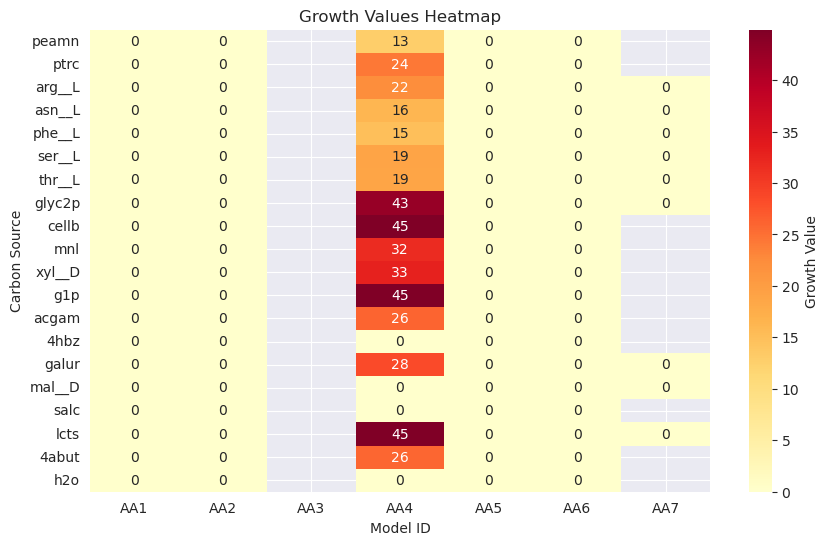

In [29]:
create_medium(ecoplate_rxns, m9_rxn, models_curation, 1000) # with benzoate (bz)
#create_medium(ecoplate_rxns, m9_rxn[:-1], models_curation, 1000)  # without bz

## Minimal media growth assay (For Cross-Feeding)

Krumbach Fig. 4a shows the 9 different carbon sources they tried out for their minimal medium grwoth assay (M9 + single carbon source)
- Glucose (glc__D)
- Sucrose (sucr)
- Xylose (xyl__D)
- Malate (mal__L or maybe mal__D)
- Pyruvate (pyr)
- Succinate (succ)
- Alanine (ala__L or maybe ala__D)
- Glutamate (glu__L or glu__D)
- Glycine (gly)

In [47]:
carbon_sources = ["EX_glc__D_e", "EX_sucr_e", "EX_xyl__D_e", ["EX_mal__L_e", "EX_mal__L_e"], "EX_pyr_e", "EX_succ_e", ["EX_ala__L_e", "EX_ala__L_e"], "EX_glu__L_e", "EX_gly_e"]

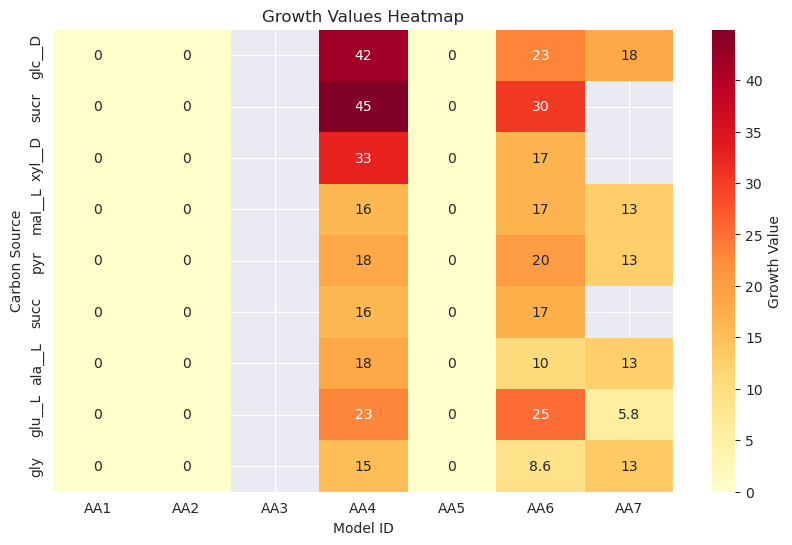

In [250]:
create_medium(carbon_sources, m9_rxn, models_curation, 1000)
# create_medium(carbon_sources, m9_rxn[:-1], models_curation)  # without bz

In [462]:
print('complete model: ', pfba(AA6).fluxes["Growth"])
with AA6:
    AA6.reactions.EX_bz_e.knock_out()
    #AA6.reactions.EX_tol_e.knock_out()
    print('bz/tol knocked out: ', pfba(AA6).fluxes["Growth"])

    print(minimal_medium(AA6, 1))

Minimization of medium was infeasible.


complete model:  67.00209821845436
bz/tol knocked out:  0.0
None


## minimal media according to cobrapy

In [106]:
max_growth = pfba(AA7).fluxes["Growth"]
minimal_medium(AA7, 2.8)

EX_adn_e            1.104158
EX_alatrp_e         0.159160
EX_bz_e             0.000280
EX_ca2_e            0.014574
EX_carn_e           0.001613
EX_cl_e             0.014574
EX_cobalt2_e        0.000280
EX_csn_e            0.926226
EX_cu2_e            0.001985
EX_dad_2_e          0.148912
EX_fe3_e            0.021862
EX_g3ps_e           2.699292
EX_glymet_e         0.432474
EX_gthrd_e          0.256508
EX_hishis_e         2.722047
EX_k_e              0.546540
EX_malttr_e        29.513138
EX_mg2_e            0.024290
EX_mn2_e            0.001935
EX_o2_e           500.425044
EX_pheme_e          0.000624
EX_salchs4fe_e      0.019426
EX_so4_e            0.012146
EX_tag180_e         0.340262
EX_thm_e            0.000624
EX_zn2_e            0.000955
dtype: float64

In [ ]:
# bz = 1, 2, 6, 7

### get essential components

In [27]:
mm = minimal_medium(AA1, 2)

In [6]:
results = []

for model_id, model in models_curation.items():
    mm = minimal_medium(model, 2)

    # Make sure it's a Series (should be, since you expect only one solution per model)
    if isinstance(mm, pd.Series):
        mm.name = model_id
        results.append(mm)
    else:
        print(f"{model_id} did not return a Series, skipping...")

# Combine all into one DataFrame
mm_df = pd.concat(results, axis=1).fillna(0).round(4)

# reactions present in all models
shared_reactions = mm_df[(mm_df != 0).all(axis=1)].index.tolist()

In [7]:
shared_reactions # only the m9 ion stuff

['EX_ca2_e',
 'EX_cl_e',
 'EX_cobalt2_e',
 'EX_cu2_e',
 'EX_k_e',
 'EX_mg2_e',
 'EX_mn2_e',
 'EX_o2_e',
 'EX_so4_e',
 'EX_zn2_e']

In [249]:
all_minimal_media = {}  # Dict to store results for each model

for model in models_filled.values():
    mm = minimal_medium(model, 2, minimize_components=5)

    # Store the DataFrame/Series as is for later analysis
    all_minimal_media[model.id] = mm

    if isinstance(mm, pd.Series):
        nonzero_reactions = mm[mm != 0].index.tolist()
        num_solutions = 1
    elif isinstance(mm, pd.DataFrame):
        nonzero_reactions = mm[(mm != 0).all(axis=1)].index.tolist()
        num_solutions = mm.shape[1]
    else:
        nonzero_reactions = []
        num_solutions = 0

    print(f"Model: {model.id}")
    print(f"Number of minimal media solutions: {num_solutions}")
    print(f"Nonzero reactions in all solutions: {nonzero_reactions}")
    print("-" * 50)

# Optional: Save each minimal medium to CSV files
for model_id, df in all_minimal_media.items():
    # If it's a Series, convert to DataFrame before saving
    if isinstance(df, pd.Series):
        df = df.to_frame(name="flux")
    #df.to_csv(f"{model_id}_minimal_medium.csv")


Model: AA1
Number of minimal media solutions: 5
Nonzero reactions in all solutions: ['EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_nmn_e', 'EX_sheme_e', 'EX_zn2_e']
--------------------------------------------------
Model: AA2
Number of minimal media solutions: 1
Nonzero reactions in all solutions: ['EX_bzalc_e', 'EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_fe3dhbzs3_e', 'EX_g3pg_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_o2_e', 'EX_thm_e', 'EX_tsul_e', 'EX_zn2_e']
--------------------------------------------------
Model: AA3
Number of minimal media solutions: 4
Nonzero reactions in all solutions: ['EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_zn2_e']
--------------------------------------------------
Model: AA4
Number of minimal media solutions: 5
Nonzero reactions in all solutions: ['EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_o2_e', 'EX_zn2_e']
-------------

In [105]:
all_minimal_media["AA1"]

,0,1,2,3,4
EX_butso3_e,0.000000,0.000000,0.000000,0.000000,0.501252
EX_bz_e,545.112891,479.732820,0.000000,306.308107,24.125274
EX_ca2_e,0.010410,0.010410,0.010410,0.010410,0.010410
EX_cl_e,0.010410,0.010410,0.010410,0.010410,0.010410
EX_cobalt2_e,0.000200,0.000200,0.000200,0.000200,0.000200
EX_cu2_e,0.001418,0.001418,0.001418,0.001418,0.001418
EX_fe2_e,0.029492,0.000000,0.456210,0.000000,0.000000
EX_fe3_e,0.000000,0.029492,0.000000,0.000000,0.029492
EX_feenter_e,0.000000,0.000000,0.000000,0.419878,0.000000
EX_gly_met_e,0.000000,0.888876,0.000000,0.000000,0.000000


In [131]:
metabolites = [
"EX_adpac_e", "EX_ala__L_e", "EX_ala__D_e", "EX_fru_e", "EX_fru_B_e", "EX_gal__l_e", "EX_gal_e", "EX_glcn_e", "EX_gly_e", "EX_ile__L_e", "EX_lac__L_e", "EX_lac__D_e", "EX_lnlc_e", "EX_malon_e", "EX_malt_e", "EX_inost_e", "EX_ocdcea_e", "EX_hdcea_e", "EX_all__D_e", "EX_rmn_e", "EX_rib__D_e", "EX_srb__L_e", "EX_succ_e", "EX_thrnt_e", "EX_urea_e", "EX_val__l_e", "EX_val__D_e", "EX_xylt_e"
]

In [127]:
metabolites = [["EX_amp_e", "EX_malt_e", "EX_isetac_e"] ] # based on the minimal medium from cobrapy this combination of carbon_sources is able to get growth for AA3
# however, only malt is in my naveed medium, i.e. because AA3 is able to grow on its own, that my medium has other metabolites that are also possible to boost growth in AA3

In [137]:
# just getting pairs, i.e. coupling 2 metabolites up (+M9) doesnt get us a growth for AA3. thats why we're doing three (but the cheap version, we're taking the pairs and adding malt to it)
import itertools
pairs = []
for pair in itertools.combinations(metabolites, 2):
    pair_list = list(pair)
    if "EX_malt_e" not in pair_list:
        pair_list.append("EX_malt_e")
    pairs.append(pair_list)

print(f"Number of pairs: {len(pairs)}")
print(pairs[:10])


Number of pairs: 378
[['EX_adpac_e', 'EX_ala__L_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_ala__D_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_fru_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_fru_B_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_gal__l_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_gal_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_glcn_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_gly_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_ile__L_e', 'EX_malt_e'], ['EX_adpac_e', 'EX_lac__L_e', 'EX_malt_e']]


['EX_adpac_e', 'EX_ala__L_e', 'EX_malt_e'] 38.07982365893718
['EX_adpac_e', 'EX_ala__D_e', 'EX_malt_e'] 38.079823658937066
['EX_adpac_e', 'EX_fru_e', 'EX_malt_e'] 38.07982365893718
['EX_adpac_e', 'EX_fru_B_e', 'EX_malt_e'] 38.079823658937066
['EX_adpac_e', 'EX_gal__l_e', 'EX_malt_e'] 38.07982365893718
['EX_adpac_e', 'EX_gal_e', 'EX_malt_e'] 38.079823658937066
['EX_adpac_e', 'EX_glcn_e', 'EX_malt_e'] 38.07982365893718
['EX_adpac_e', 'EX_gly_e', 'EX_malt_e'] 38.6944917938718
['EX_adpac_e', 'EX_ile__L_e', 'EX_malt_e'] 38.456213527629004
['EX_adpac_e', 'EX_lac__L_e', 'EX_malt_e'] 3.30818256660699
['EX_adpac_e', 'EX_lac__L_e', 'EX_malt_e'] 38.07982365893709
['EX_adpac_e', 'EX_lac__D_e', 'EX_malt_e'] 38.07982365893686
['EX_adpac_e', 'EX_lnlc_e', 'EX_malt_e'] 38.07982365893709
['EX_adpac_e', 'EX_malon_e', 'EX_malt_e'] 38.07982365893696
['EX_adpac_e', 'EX_malt_e'] 38.07982365893709
['EX_adpac_e', 'EX_inost_e', 'EX_malt_e'] 38.07982365893696
['EX_adpac_e', 'EX_ocdcea_e', 'EX_malt_e'] 39.4151457

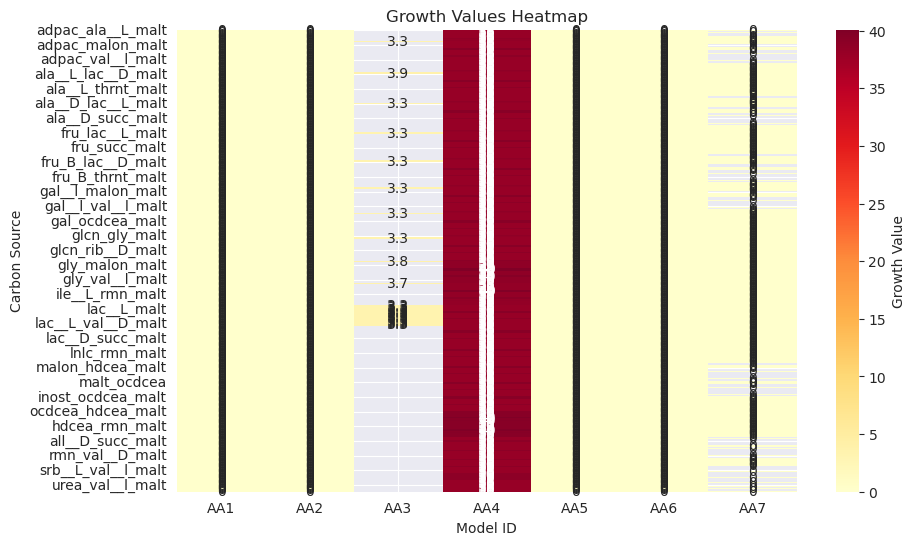

In [152]:
create_medium(pairs, m9_rxn[:-1], models_curation, 1000)

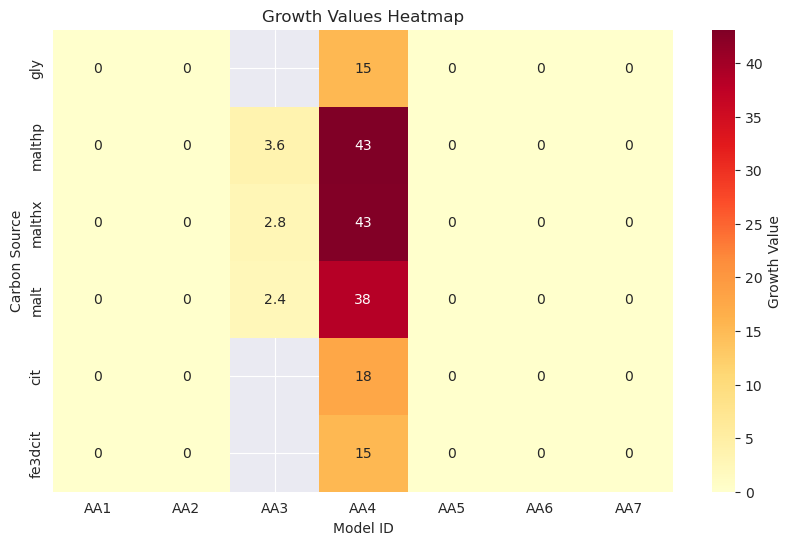

In [102]:
AA3_sources = ["EX_gly_e", ["EX_malthp_e", "EX_fe3dcit_e"], ["EX_malthx_e", "EX_fe3dcit_e"], ["EX_malt_e", "EX_fe3dcit_e"], "EX_cit_e", "EX_fe3dcit_e"]
#create_medium(AA3_sources, m9_rxn, models_curation, 1000)
create_medium(AA3_sources, m9_rxn[:-1], models_curation, 1000)  # without bz

In [92]:
get_met(AA3, "fe3dcit_e")

Fe(III)dicitrate (C12H10FeO14)
{'EX_fe3dcit_e': 'fe3dcit_e <=> ', 'FE3DCITabc': 'atp_c + fe3dcit_e + h2o_c --> adp_c + 2.0 cit_c + fe3_c + h_c + pi_c'}


In [103]:
get_met(AA3, "malthp_e")

Maltoheptaose (C42H72O36)
{'EX_malthp_e': 'malthp_e <=> ', 'MALTHPabc': 'atp_c + h2o_c + malthp_e --> adp_c + h_c + malthp_c + pi_c'}


# Metabolic niches & what do our bacteria need
The first steps in the Krumbach paper where analysing what the bacteria uptake (depletion of metabolites/Exometabolomic profiling). Bacteria where grown on maize roots in combination with the M9 medium. Additionally gaining information about the metabolites that bacteria release into the medium.
For me, I also want to check under which conditions my bacteria grow because most/some of them dont grow on Maize ARE + M9

In [25]:
med_wo_bz = medium_combined_naveed[medium_combined_naveed['reaction'] != 'EX_bz_e']

In [114]:
for model in models_filled.values():
    growth_val = test_medium(model, medium_combined_krumbach)
    print(model.id, ": ", growth_val)

AA1 :  12.024833169938834
AA2 :  0.0
AA3 :  None
AA4 :  16.735081796546574
AA5 :  12.54688059553392
AA6 :  15.041286709543934
AA7 :  10.28466767704832


In [231]:
for model in models_curation.values():
    growth_val = test_medium(model, medium_combined_naveed)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  None
AA4 :  16.838073691204894
AA5 :  0.0
AA6 :  14.00488705696367
AA7 :  11.229605821567311


In [116]:
for model in models_filled.values():
    growth_val = test_medium(model, medium_beck)
    print(model.id, ": ", growth_val)

AA1 :  5.0030164718646475
AA2 :  14.158584134035308
AA3 :  None
AA4 :  10.92502857049456
AA5 :  10.859283612963122
AA6 :  10.973764769857768
AA7 :  5.611053221570555


AA3 and AA4 can grow with M9 and Maize ARE. AA3 needs high amount of carbon, so bounds = 10 for carbon sources is not sufficient for AA3.
AA6 and AA7 only in the presence of benzoate.

In [28]:
for model in models_curation.values():
    growth_val = test_medium(model, med_wo_bz)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  None
AA4 :  16.838073691204876
AA5 :  0.0
AA6 :  0.0
AA7 :  0.0


In [30]:
AA2_requirements = list(minimal_medium(AA2, 5).index)

EX_LalaDgluMdapDala_e 13.785416889961658
EX_LalaDgluMdapDala_e 56.36816608384103
EX_LalaDgluMdapDala_e 41.32510719422859
EX_LalaDgluMdapDala_e 22.518900225553793
EX_LalaDgluMdap_e 13.779718115196403
EX_LalaDgluMdap_e 56.368166083841075
EX_LalaDgluMdap_e 41.325107194228714
EX_LalaDgluMdap_e 22.51890022555378
EX_ade_e 14.370657187397994
EX_ade_e 59.18393783437544
EX_ade_e 43.50186472918269
EX_ade_e 26.192456072650838
EX_alatrp_e 13.844784213601148
EX_alatrp_e 56.32405425048403
EX_alatrp_e 41.487533867311114
EX_alatrp_e 22.72250048575017
EX_arg__L_e 14.125157055855627
EX_arg__L_e 71.29592129295311
EX_arg__L_e 42.36071102792335
EX_arg__L_e 27.888977955188867
EX_bz_e 13.779718115196419
EX_bz_e 56.324054250484316
EX_bz_e 41.32510719422878
EX_bz_e 22.51890022555378
EX_ca2_e 13.7797181151964
EX_ca2_e 56.32405425048424
EX_ca2_e 41.325107194228664
EX_ca2_e 22.518900225553754
EX_cl_e 13.779718115196367
EX_cl_e 56.32405425048418
EX_cl_e 41.325107194228785
EX_cl_e 22.51890022555386
EX_cobalt2_e 13.

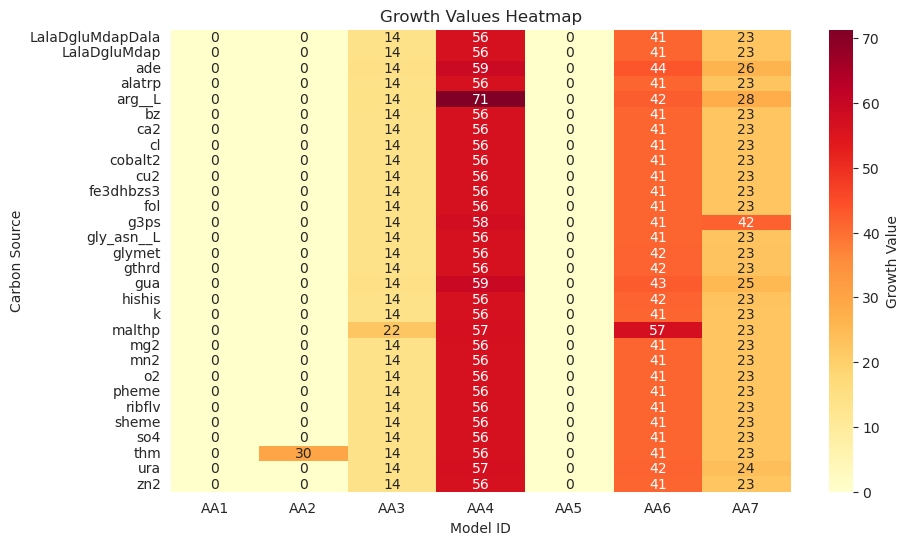

In [31]:
create_medium(AA2_requirements, list(medium_combined_krumbach["reaction"]), models_curation, 1000)

AA2 needs (in addition to the maize root, M9 (+ bz)) thiamin (vitamin B1) to grow. \
For AA1 and AA5 there was still no growth if we add one of their metabolites from their required minimal medium at a time. \
Some metabolites, e.g. malthp can boost growth

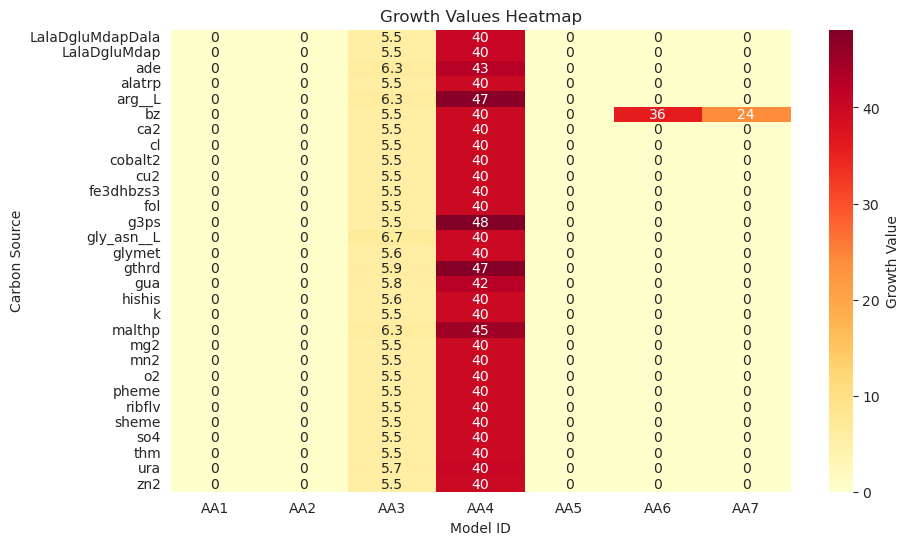

In [184]:
create_medium(AA2_requirements, list(med_wo_bz["reaction"]), models_curation, 1000)

If bz is missing then AA2 canNOT grow even if thm (thiamine) is present. As already known, AA6 and AA7 only grow with bz

What do AA1 and AA5 need to grow?

In [113]:
min_AA1 = minimal_medium(AA1, 3)
min_AA1 = min_AA1.reset_index()
min_AA1.columns = ['reaction', 'flux']

In [114]:
# without bz
filtered_df = min_AA1[~min_AA1['reaction'].isin(med_wo_bz["reaction"])]

In [121]:
import itertools
reaction_pairs = [list(pair) for pair in itertools.combinations(filtered_df["reaction"], 4)]

In [122]:
for extra_rxns in reaction_pairs:
    new_medium = list(med_wo_bz["reaction"]) + extra_rxns
    med_dict = {new_medium[i]: 1000 for i in range(len(new_medium))}
    growth_val = test_medium(AA1, med_dict)
    if growth_val != 0:
        print(extra_rxns, ": ", growth_val)

['EX_bz_e', 'EX_nmn_e', 'EX_orn__D_e', 'EX_sheme_e'] :  26.531375400960357


AA1 needs nmn, orn__D and sheme and bz
- nmn: β-Nicotinamide mononucleotide is a naturally occurring molecule derived from ribose and nicotinamide (a form of vitamin B3). It's a precursor to NAD+
- ornithine (gets turned into proline which is important for growth)
- Siroheme is needed for growth; all other models with siroheme (all besides AA3) have the SHCHF reaction to synthesise sheme from fe2 and scl
- benzoate

In [158]:
min_AA5 = minimal_medium(AA5, 3)
min_AA5 = min_AA5.reset_index()
min_AA5.columns = ['reaction', 'flux']

In [160]:
# without bz
filtered_df = min_AA5[~min_AA5['reaction'].isin(med_wo_bz["reaction"])]
reaction_pairs = [list(pair) for pair in itertools.combinations(filtered_df["reaction"], 2)]

In [161]:
for extra_rxns in reaction_pairs:
    new_medium = list(med_wo_bz["reaction"]) + extra_rxns
    med_dict = {new_medium[i]: 1000 for i in range(len(new_medium))}
    growth_val = test_medium(AA5, med_dict)
    if growth_val != 0:
        print(extra_rxns, ": ", growth_val)

['EX_acgam1p_e', 'EX_arg__L_e'] :  31.95459044255872


AA5 needs acgam1p and arg__L:
- it is noted that it does not need bz to grow
- N-Acetyl-D-glucosamine 1-phosphate: in _c is in all models, however only AA4 and AA5 have it in _e; AA5 uses it to make uacgam
- Arginine

## Secretion

AA3 and AA4 can grow on the M9+Maize medium (AA3 depends on bounds). \
AA6 and AA7 need benzoate (bz). AA2 needs bz and thiamine (thm). \
AA1 needs nmn, orn__D and sheme and bz. \
AA5 needs acgam1p and arg__L.

In [74]:
needed = ["bz_e", "thm_e", "nmn_e", "orn__D_e", "sheme_e", "acgam1p_e", "arg__L_e"]

In [ ]:
needed_more = ["bz_e", "thm_e", "nmn_e", "orn__D_e", "sheme_e", "acgam1p_e", "arg__L_e", "orn_e"] # alternative orn ID

In [32]:
for met in needed:
    get_met_unknown(models_curation, met)

bz_e (Benzoate (C7H5O2, -1)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'BZt', 'BZtex', 'EX_bz_e'}
thm_e (Thiamin (C12H17N4OS, 1)) is found  models: ['AA2', 'AA3', 'AA4', 'AA5', 'AA7'] and in reactions: {'THMabc', 'THMtrbc', 'THMtex', 'EX_thm_e'}
nmn_e (NMN C11H14N2O8P (C11H14N2O8P, -1)) is found  models: ['AA1', 'AA2', 'AA4', 'AA5'] and in reactions: {'NMNtex', 'NMNP', 'EX_nmn_e', 'NMNR'}
orn__D_e (D-Ornithine (C5H13N2O2, 1)) is found  models: ['AA1', 'AA7'] and in reactions: {'EX_orn__D_e', 'DORNtex'}
sheme_e (Siroheme C42H36FeN4O16 (C42H36FeN4O16, -8)) is found  models: ['AA1', 'AA2', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'EX_sheme_e', 'SHEMEtonex'}
acgam1p_e (N-Acetyl-D-glucosamine 1-phosphate (C8H14NO9P, -2)) is found  models: ['AA4', 'AA5'] and in reactions: {'ACGAM1P_Et', 'ACGAM1Ptex', 'EX_acgam1p_e'}
arg__L_e (L-Arginine (C6H15N4O2, 1)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'AR

In [68]:
# AA1 cannot convert orn__D into orn or other way round but maybe other models could secrete orn?
get_met_unknown(models_curation, "orn_e")

orn_e (Ornithine (C5H13N2O2, 1)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'ORNtex', 'ORNt', 'ARGORNt3', 'EX_orn_e', 'PTRCORNt7', 'ORNabc'}


In [82]:
model_pfba = pfba(AA7).fluxes
model_pfba[(model_pfba.index.str.contains('thm_e'))]

EX_thm_e   -0.012337
Name: fluxes, dtype: float64

In [79]:
def secrets(model):
    model_pfba = pfba(model).fluxes
    model_pfba = model_pfba.reset_index()
    model_pfba.columns = ['rxn', 'flux']

    model_pfba_ex = model_pfba[model_pfba['rxn'].str.startswith('EX_') & (model_pfba['flux'] > 0)]

    for needed_met in needed:
    #for needed_met in needed_more:
        if str("EX_"+needed_met) in list(model_pfba_ex["rxn"]):
            print(needed_met, "in", model.id)

    #return model_pfba_ex

In [80]:
for model in models_curation.values():
    secrets(model)

In [233]:
secrets(AA7)

,rxn,flux
82,EX_co2_e,1000.000000
121,EX_gal_e,1000.000000
140,EX_glyc_e,53.332424
177,EX_leu__L_e,264.904238
198,EX_nh4_e,527.857552
211,EX_orn_e,114.747420
226,EX_pi_e,1000.000000
258,EX_succ_e,315.258666


# pFBA
pfba() and summary() do pFBA; optimize() does FBA
Nadine advised my to use pFBA and not normal FBA (because with the additional objective of trying to minimise the amount of fluxes, maybe it is not going to use weird cycles)

In [248]:
def uptakes_pfba(model):
    model_pfba = model.summary()
    return model_pfba.uptake_flux

In [249]:
aa2_uptake = uptakes_pfba(AA2)

In [250]:
aa2_uptake

,flux,reaction,metabolite
EX_LalaDgluMdapDala_e,1.545674,EX_LalaDgluMdapDala_e,LalaDgluMdapDala_e
EX_acald_e,1000.000000,EX_acald_e,acald_e
EX_ade_e,11.363774,EX_ade_e,ade_e
EX_akg_e,200.269532,EX_akg_e,akg_e
EX_ala_B_e,0.032039,EX_ala_B_e,ala_B_e
EX_arg__L_e,16.453072,EX_arg__L_e,arg__L_e
EX_asn__L_e,13.408393,EX_asn__L_e,asn__L_e
EX_bz_e,0.005562,EX_bz_e,bz_e
EX_ca2_e,0.289522,EX_ca2_e,ca2_e
EX_cl_e,0.289522,EX_cl_e,cl_e


In [233]:
fluxies = pfba(AA1).fluxes

In [234]:
sus_fluxies = []
for rxn, flux in fluxies.items():
    if flux > 300 or flux < -300:
        sus_fluxies.append((rxn, flux))

In [235]:
sus_EX = []
for rxn, flux in fluxies.items():
    if rxn.startswith("EX_") and flux != 0 and (flux < -1 or flux > 1):
        sus_EX.append((rxn, flux))

In [236]:
sus_EX

[('EX_adn_e', -5.875622772358431),
 ('EX_ala_L_thr__L_e', -17.947579929403524),
 ('EX_ala_his_e', -3.124917898668356),
 ('EX_arg__L_e', -9.756652189015076),
 ('EX_co2_e', 246.53159033295427),
 ('EX_cytd_e', -10.06713850052856),
 ('EX_galt_e', -476.0029836768078),
 ('EX_gam_e', -3.116671688333885),
 ('EX_gly_asn__L_e', -7.951160928703377),
 ('EX_gly_phe_e', -6.110936630462887),
 ('EX_glyc3p_e', -31.723336080915743),
 ('EX_glyglygln_e', -8.717068944569021),
 ('EX_gua_e', -7.131685530505013),
 ('EX_h2o_e', 855.2144325569088),
 ('EX_h2s_e', 6.0254564141357605),
 ('EX_h_e', 784.664153210762),
 ('EX_hxan_e', -16.47497168787375),
 ('EX_id3acald_e', -1.874957336169281),
 ('EX_k_e', -6.438410135265389),
 ('EX_lac__L_e', 800.8676596544242),
 ('EX_lys__L_e', -13.379839100933488),
 ('EX_met_L_ala__L_e', -5.079962429606017),
 ('EX_o2_e', -354.7964362781599),
 ('EX_pro__L_e', -7.291464101945718),
 ('EX_s_e', -9.069264587954255),
 ('EX_tre_e', -9.535191964272464),
 ('EX_tyr__D_e', -4.555833300747056)

In [219]:
sus_fluxies

[('EX_galt_e', -475.8912337268235),
 ('EX_h2o_e', 855.1026826069252),
 ('EX_h_e', 785.2736983924979),
 ('EX_lac__L_e', 801.5991138725079),
 ('EX_o2_e', -353.9786298259979),
 ('ATPS4rpp', 1000.0),
 ('CT6PT', 475.8912337268235),
 ('CYTBO3_4pp', 681.6683997322916),
 ('ENO', 1000.0),
 ('GALTpts', 475.8912337268235),
 ('GAPD', 1000.0),
 ('GLTPD', 475.8912337268235),
 ('H2Ot', -855.1026826069252),
 ('Htex', -800.3548956096392),
 ('LACLt2', -801.5991138725079),
 ('LDH_L', -801.5991138725079),
 ('NADH16pp', 681.6683997322916),
 ('O2tex', 353.9786298259979),
 ('O2tpp', 353.9786298259979),
 ('PGK', -1000.0),
 ('PGM', -1000.0),
 ('PYK4', 481.8059435361673),
 ('TGBPA', 475.8912337268235),
 ('TPI', 513.3978985463364)]

## get all uptakes

In [253]:
# Step 1: Collect all unique EX reactions
all_rxns = set()

# Also store each model's uptake flux dict
uptake_flux_dicts = []

for model in models_curation.values():
    uptake_fluxes = {
        rxn: flux
        for rxn, flux in pfba(model).fluxes.items()
        if rxn.startswith("EX_") and flux < 0
    }
    all_rxns.update(uptake_fluxes.keys())
    uptake_flux_dicts.append(uptake_fluxes)

# Step 2: Create empty DataFrame with full reaction list as index
df_uptake_fluxes = pd.DataFrame(index=sorted(all_rxns))  # sorted optional

# Step 3: Fill in each model's uptake data
for i, uptake_fluxes in enumerate(uptake_flux_dicts, start=1):
    df_uptake_fluxes[f'AA{i}'] = pd.Series(uptake_fluxes)


## Auswirkungen der ATPM Reaktion auf Biomasse
Auswirkungen sind sehr gering, also Fluss durch ATPM = 10 ist schon sehr hoch und Biomasse ändert sich maximal in ~1-2. Kommastelle

In [497]:
with AA7:
    print(AA7.summary())
    atpm_flux = 10
    AA7.reactions.get_by_id("ATPM").lower_bound = atpm_flux
    AA7.reactions.get_by_id("ATPM").upper_bound = atpm_flux
    print(AA7.summary())

Objective
1.0 Growth = 55.322197071522055

Uptake
------
Metabolite      Reaction     Flux  C-Number C-Flux
    4abz_e     EX_4abz_e  0.03701         7  0.00%
   5mcsn_e    EX_5mcsn_e  0.01787         5  0.00%
     adn_e      EX_adn_e    9.855        10  0.77%
     akg_e      EX_akg_e    30.69         5  1.19%
  arg__L_e   EX_arg__L_e    131.1         6  6.12%
  asn__L_e   EX_asn__L_e    13.34         4  0.41%
      bz_e       EX_bz_e 0.005532         7  0.00%
     ca2_e      EX_ca2_e    0.288         0  0.00%
    chor_e     EX_chor_e    10.25        10  0.80%
      cl_e       EX_cl_e    0.288         0  0.00%
 cobalt2_e  EX_cobalt2_e 0.005532         0  0.00%
     cu2_e      EX_cu2_e  0.03922         0  0.00%
  cys__L_e   EX_cys__L_e    5.098         3  0.12%
   dad_2_e    EX_dad_2_e    1.448        10  0.11%
     fe2_e      EX_fe2_e   0.3715         0  0.00%
     fe3_e      EX_fe3_e    0.432         0  0.00%
    g3pg_e     EX_g3pg_e    53.33         6  2.49%
     gly_e      EX_gly_e 

In [496]:
with AA7:
    change_medium(AA7, medium_combined_krumbach)
    print(AA7.summary())
    atpm_flux = 10
    AA7.reactions.get_by_id("ATPM").lower_bound = atpm_flux
    AA7.reactions.get_by_id("ATPM").upper_bound = atpm_flux
    print(AA7.summary())

Objective
1.0 Growth = 24.999898439610885

Uptake
------
Metabolite     Reaction     Flux  C-Number C-Flux
      bz_e      EX_bz_e   0.0025         7  0.00%
     ca2_e     EX_ca2_e   0.1301         0  0.00%
      cl_e      EX_cl_e   0.1301         0  0.00%
 cobalt2_e EX_cobalt2_e   0.0025         0  0.00%
     cu2_e     EX_cu2_e  0.01772         0  0.00%
     fe2_e     EX_fe2_e    0.179         0  0.00%
     fe3_e     EX_fe3_e   0.1952         0  0.00%
     fru_e     EX_fru_e    485.8         6 68.95%
     gly_e     EX_gly_e    63.92         2  3.02%
  ile__L_e  EX_ile__L_e    7.263         6  1.03%
   inost_e   EX_inost_e   0.0144         6  0.00%
       k_e       EX_k_e     4.88         0  0.00%
    lnlc_e    EX_lnlc_e     54.5        18 23.21%
     mg2_e     EX_mg2_e   0.2169         0  0.00%
     mn2_e     EX_mn2_e  0.01727         0  0.00%
     nh4_e     EX_nh4_e    198.4         0  0.00%
      o2_e      EX_o2_e    638.5         0  0.00%
  ocdcea_e  EX_ocdcea_e    8.897        18 

# FVA

In [ ]:
fva1 = flux_variability_analysis(AA1)

In [24]:
# reactions that do not have a flux
for rxn in fva1.iterrows():
    # first[]: [0] gets index aka rxn name and [1] accesses the data; second []: [0] minimum and [1] maximum
    if rxn[1][0] == 0 and rxn[1][1] == 0:
        print(rxn[0])

EX_6apa_e
EX_R_3hpba_e
EX_apc_e
EX_arab__L_e
EX_cd2_e
EX_ch4s_e
EX_cm_e
EX_cro4_e
EX_dca_e
EX_ddca_e
EX_doxrbcn_e
EX_enter_e
EX_feenter_e
EX_for_e
EX_fusa_e
EX_glcur_e
EX_gly_asp__L_e
EX_gly_leu_e
EX_gly_pro__L_e
EX_gly_tyr_e
EX_h2_e
EX_hxa_e
EX_ile__L_e
EX_inost_e
EX_isetac_e
EX_m_xyl_e
EX_mal__D_e
EX_na1_e
EX_ni2_e
EX_nona_e
EX_novbcn_e
EX_octa_e
EX_oxa_e
EX_p_xyl_e
EX_phedca_e
EX_phehpa_e
EX_phenona_e
EX_pheocta_e
EX_pta_e
EX_ptrc_e
EX_quin_e
EX_salchs4fe_e
EX_serglugly_e
EX_ttrcyc_e
2AGPE160tipp
2AGPG160tipp
2AGPG181tipp
3MBtex
4ABUTabcpp
6APAt1
AACPS5
AALDH
ACCOAC
ACGAMK
ACGK_1
ACGS
ACPPAT181
ACPS1
ACPpds
ADSL1r
ADSL2r
ADSS
AGPAT181
AHGDx
AICART
ALAALAD_1
ALDD31
AM3PA
AMPEP18
ANS
APTNAT
ASPK
ATPPRT
BGLA
BPNT2
BZDH
CINNMCOAH
CINNMtex
CINNMtpp
DAGK160
DHBD
DHBS
DHDPRx_r
DHQS
DHQTi
DKMPPD3
DLEUabcpp
DLEUtex
ECOAH15
ENTCS
FAS120
FEENTERR4
FEENTERabcpp
FEENTERtex
FEENTERtonex
FEENTERtpp
FORtex
G3PAT181
G3PEabcpp
G3PGabcpp
GALM1
GALUi
GCVHADPr
GCVHRADPr
GGDAPAH
GGDAPDxr
GGDAPO
GGDAPS
GG

In [25]:
get_rxn_unknown(models_curation, "NTP1", bounds=True)

NTP1 is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
NTP1: atp_c + h2o_c --> adp_c + h_c + pi_c
{'atp_c': -4, 'h2o_c': 0, 'adp_c': -3, 'h_c': 1, 'pi_c': -2}
lower bound: {0.0}; upper bound: {1000.0}


In [26]:
get_rxn_unknown(models_curation, "ATPM", bounds=True)

ATPM is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
{'atp_c': -4, 'h2o_c': 0, 'adp_c': -3, 'h_c': 1, 'pi_c': -2}
lower bound: {0.0}; upper bound: {1000.0}


In [491]:
def get_high_atp_fluxes(model, threshold, medium=None, mode="fva"):
    if medium is not None:
        with model:
            change_medium(model, medium)
    if mode == "fva":
        res = flux_variability_analysis(model)

        for row in res.iterrows():
            rxn = model.reactions.get_by_id(row[0])
            mets = [met.id for met in rxn.metabolites]
            if "atp_c" in mets:
                if abs(row[1][0]) > threshold: # accesses minimum flux value
                    print(rxn, ":", row[1][0],"-",row[1][1])

    else: #pfba
        res = pfba(model).fluxes
        res = res.rename("bound").reset_index().rename(columns={"index": "reaction"})
        for ind, row in res.iterrows():
            rxn = model.reactions.get_by_id(row[0])
            mets = [met.id for met in rxn.metabolites]
            if "atp_c" in mets:
                if abs(row[1]) > threshold: # accesses flux value
                    print(rxn, "/", row[1])


In [ ]:
fva7 = flux_variability_analysis(AA7)

In [35]:
for row in fva7.iterrows():
    if row[1][0] == 1000 and row[1][1] == 1000:
        print(row[0])

NameError: name 'fva7' is not defined

In [489]:
get_high_atp_fluxes(AA7, 500, medium_combined_krumbach, mode="pfba")

A6PAG: atp_c + gal_c --> adp_c + dgal6p_c + h_c : 999.9999999999932
ATPS4rpp: adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c : 1000.0
GALKr: atp_c + gal_c <=> adp_c + gal1p_c + h_c : -999.9999999999932
NDPK5: atp_c + dgdp_c <=> adp_c + dgtp_c : -951.7664573280334
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c : -1000.0
PYDXNK: atp_c + pydxn_c --> adp_c + h_c + pdx5p_c : 758.183923257179
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c : 1000.0


In [490]:
get_high_atp_fluxes(AA7, 500, medium_combined_krumbach, mode="fva")

A6PAG: atp_c + gal_c --> adp_c + dgal6p_c + h_c : 999.999999999978 - 1000.0
ADK1: amp_c + atp_c <=> 2.0 adp_c : -920.9137105988292 - 1000.0
ATPS4rpp: adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c : 999.9999999999975 - 1000.0
CBMKr: atp_c + co2_c + nh4_c <=> adp_c + cbp_c + 2.0 h_c : -893.6412377308338 - -114.74742021106897
GALKr: atp_c + gal_c <=> adp_c + gal1p_c + h_c : -1000.0 - -999.9999999999868
NDPK1: atp_c + gdp_c <=> adp_c + gtp_c : -1000.0 - 1000.0
NDPK5: atp_c + dgdp_c <=> adp_c + dgtp_c : -998.5053602017186 - -587.6799593480126
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c : -1000.0 - -999.9999999999969
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c : 589.174599146307 - 1000.0


In [53]:
get_high_atp_fluxes(AA2, 500)

ADK1: amp_c + atp_c <=> 2.0 adp_c : -1000.0 - 1000.0
ATPS4rpp: adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c : 1000.0000000000016 - 1000.0
CYTK1: atp_c + cmp_c <=> adp_c + cdp_c : -990.0578036109398 - 1000.0
CYTK2: atp_c + dcmp_c <=> adp_c + dcdp_c : -1000.0 - 1000.0
GK1: atp_c + gmp_c <=> adp_c + gdp_c : -985.0773049957444 - 1000.0
NDPK1: atp_c + gdp_c <=> adp_c + gtp_c : -1000.0 - 1000.0
NDPK3: atp_c + cdp_c <=> adp_c + ctp_c : -1000.0 - 1000.0
NDPK5: atp_c + dgdp_c <=> adp_c + dgtp_c : -998.4972120407115 - 1.5027879592874234
NDPK8: atp_c + dadp_c <=> adp_c + datp_c : -985.0773049957444 - 1000.0
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c : -1000.0 - -1000.0000000000064
SUCOAS: atp_c + coa_c + succ_c <=> adp_c + pi_c + succoa_c : -1000.0 - -375.5124529877826


In [54]:
get_high_atp_fluxes(AA7, 500)

A6PAG: atp_c + gal_c --> adp_c + dgal6p_c + h_c : 999.999999999986 - 1000.0
ADK1: amp_c + atp_c <=> 2.0 adp_c : -920.9137105988359 - 1000.0
ATPS4rpp: adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c : 999.9999999999964 - 1000.0
CBMKr: atp_c + co2_c + nh4_c <=> adp_c + cbp_c + 2.0 h_c : -893.6412377308416 - -114.74742021104703
GALKr: atp_c + gal_c <=> adp_c + gal1p_c + h_c : -1000.0 - -999.9999999999923
NDPK1: atp_c + gdp_c <=> adp_c + gtp_c : -1000.0 - 1000.0
NDPK5: atp_c + dgdp_c <=> adp_c + dgtp_c : -998.5053602017186 - -587.6799593479941
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c : -1000.0 - -999.9999999999925
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c : 589.1745991462517 - 1000.0


# Budget Plots
Credits go to Tiago who originally wrote the Code for creating Budget Plots, I only changed minor things

## Functions

In [26]:
def fba_and_query(model, met_query, medium=None):
    #med = minimal_medium(model, 3, minimize_components=True)
    with model:
        try:
            #df_filtered = medium_mre_m9[medium_mre_m9['reaction'] != 'EX_nmn_e']
            if medium is not None:
                change_medium(model, medium)
            fluxes = pfba(model)
            if fluxes["Growth"] == 0:
                print("No growth")
        except Infeasible:
            print("Infeasible")
            return None, None
    solution_frame=fluxes.to_frame()

    budget_mets = []
    for met in model.metabolites.query(met_query):
        budget_mets.append(met)

    print(budget_mets)
    return budget_mets, solution_frame

In [27]:
#Remove reactions with negative flux from old list
def remove_items(test_list, item):
    res = [i for i in test_list if i != item]
    return res

In [28]:
def calc_producer_consumer(model, budget_mets, solution_frame):
    #Defining list of reactions producing and consuming the metabolite
    consumers = []
    producers = []

    #Add reactions to respective list and exclude transport reactions
    for met in budget_mets:
        for reaction in model.reactions:
            if met in reaction.reactants:
                consumers.append(reaction.id)
            elif met in reaction.products:
                producers.append(reaction.id)

    #Get flux values from the simulation for metabolite consuming/producing reactions
    producers_df = solution_frame.loc[producers,:]
    consumers_df = solution_frame.loc[consumers,:]

    #Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
    negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
    negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)

    #Add reactions to correct list
    consumers.extend(negative_producers)
    producers.extend(negative_consumers)

    for item in negative_producers:
        producers = remove_items(producers, item)

    for item in negative_consumers:
        consumers = remove_items(consumers, item)

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    producers_df = solution_frame.loc[producers,:]
    #Make all values positive (disregard directionality)
    producers_df["fluxes"] = producers_df["fluxes"].abs()
    #Remove reactions with zero flux
    producers_df = producers_df[producers_df["fluxes"] != 0]

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    consumers_df = solution_frame.loc[consumers,:]
    #Make all values positive (disregard directionality)
    consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
    #Remove reactions with zero flux
    consumers_df = consumers_df[consumers_df["fluxes"] != 0]

    #Sum the flux values
    print("Sum of consumer fluxes: {}".format(consumers_df ["fluxes"].sum(axis=0)))
    print("Sum of producer fluxes: {}".format(producers_df ["fluxes"].sum(axis=0)))

    producers_df["Status"] = "Producer"
    consumers_df["Status"] = "Consumer"

    frame = [producers_df, consumers_df]
    all_reactions = pd.concat(frame)
    all_reactions["label"] = all_reactions.index

    return all_reactions


In [32]:
def make_budget_plot(all_reactions,budget_mets, save = False):
    #Defining the nº of colors
    number_of_colors = len(all_reactions.index)

    #Getting a list of colors
    random.seed(177)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]

    #Getting list of reactions
    reaction_list = list(all_reactions.index)

    #Build color dictionary
    color_dict = {}
    for i in range(len(reaction_list)):
        color_dict[reaction_list[i]] = color[i]


    """
    Plot the pivot table and barplot
    """
    mets = [met.id for met in budget_mets]

    chart = all_reactions.pivot_table(index="Status", columns="label", values="fluxes")
    chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
    plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
    plt.title(f"Budget Plot for {mets}" )
    figsize = [11, 14] #To prevent the cropping of the image

    if save == True:
        plt.savefig('Budget_plot.svg', format='svg', bbox_inches = 'tight', dpi=600) #Line to save the image

    return chart.T

## Query

In [69]:
budget_mets, solution_frame = fba_and_query(AA4, "^glu5sa_c", medium_combined_naveed)

[<Metabolite glu5sa_c at 0x706aa27dd750>]


## Create Plot

In [70]:
all_reactions = calc_producer_consumer(AA4, budget_mets, solution_frame)

Sum of consumer fluxes: 3.7221403798092916
Sum of producer fluxes: 3.7221403798092916


Status,Consumer,Producer
label,,
G5SADs,3.72214,NaN
G5SD,NaN,3.72214


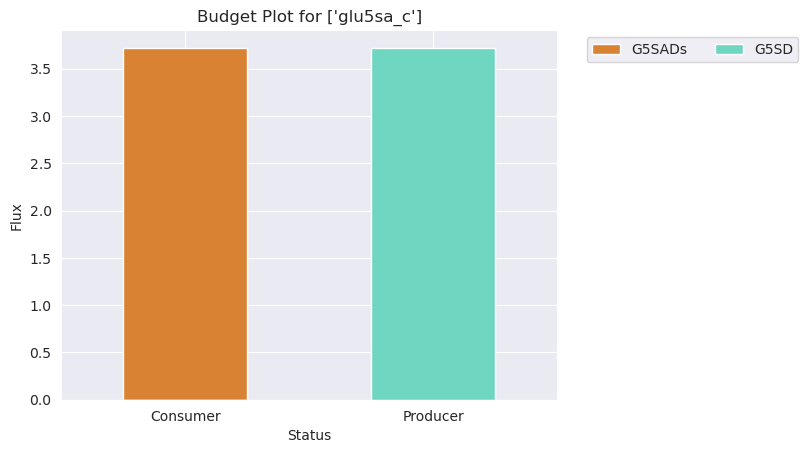

In [71]:
budget_plot = make_budget_plot(all_reactions, budget_mets)
budget_plot

# Comparison with iJN1463 (change medium bounds)

In [443]:
pseudo = read_sbml_model("../Models/iJN1463.xml")
pseudo.solver = 'cplex'

In [519]:
pseudo.medium

{'EX_ca2_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_co2_e': 100.0,
 'EX_cobalt2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_glc__D_e': 6.0,
 'EX_h2o_e': 100.0,
 'EX_h_e': 100.0,
 'EX_hco3_e': 10.0,
 'EX_k_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_nh4_e': 30.0,
 'EX_ni2_e': 10.0,
 'EX_o2_e': 100.0,
 'EX_pi_e': 10.0,
 'EX_sel_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_tungs_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_acmtsoxin_e': 1000.0,
 'EX_acpptrn_e': 1000.0,
 'EX_d2one_e': 1000.0,
 'EX_d3one_e': 1000.0,
 'EX_d4one_e': 1000.0,
 'EX_mtsoxin_e': 1000.0,
 'EX_n2one_e': 1000.0,
 'EX_pptrn_e': 1000.0,
 'EX_und2one_e': 1000.0}

In [80]:
# comparing biomass components
for met in pseudo.reactions.BIOMASS_KT2440_WT3.metabolites:
    if met not in AA7.metabolites:
        print(pseudo.metabolites.get_by_id(met.id))

2fe2s_c
4fe4s_c
adocbl_c
bmocogdp_c
btamp_c
cpe160_c
cpg160_c
hemeO_c
lipopb_c
lpspput_e
mocogdp_c
pe140_c


In [452]:
# change medium
def change_medium(model, medium_dict):
    # when I read the csv files with medium info it is saved as a dataframe, but i want a dict
    if isinstance(medium_dict, pd.DataFrame):
        medium_dict = dict(zip(medium_dict.reaction, medium_dict.bound))

    # Only include reactions that are in the model
    valid_medium = {
        rxn: bound for rxn, bound in medium_dict.items()
        if rxn in model.reactions
    }
    model.medium = valid_medium
    #print(valid_medium)


# changes medium, does pfba and returns growth rate
def test_medium(model, medium_dict):
    with model:
        change_medium(model, medium_dict)
        try:
            solution = pfba(model)
            if model.id == "iJN1463":
                growth = solution.fluxes["BIOMASS_KT2440_WT3"]
            else:
                growth = solution.fluxes["Growth"]
            return growth
        except Infeasible:
            return None

In [448]:
test_medium(pseudo, pseudo.medium)

0.5861175448479796

In [93]:
# comparison medium components
print("not in AA7")
for rxn in pseudo.medium:
    if rxn not in AA7.reactions:
        print(pseudo.reactions.get_by_id(rxn).id)

print("not in AA7 medium")
for rxn in pseudo.medium:
    if rxn in AA7.reactions and rxn not in list(medium_combined_krumbach["reaction"]):
        print(pseudo.reactions.get_by_id(rxn).id)

not in AA7
EX_hco3_e
EX_tungs_e
EX_acmtsoxin_e
EX_acpptrn_e
EX_d2one_e
EX_d3one_e
EX_d4one_e
EX_mtsoxin_e
EX_n2one_e
EX_pptrn_e
EX_und2one_e
not in AA7 medium
EX_co2_e
EX_glc__D_e
EX_h2o_e
EX_ni2_e
EX_sel_e


In [505]:
# overwrite bounds in medium using iJN1463 medium bounds
# also changing bounds of ATPM reaction
def overwrite_with_pseudo(model, atpm_flux):
    with model:
        change_medium(model, medium_combined_krumbach)
        # Get medium dicts
        pseudo_medium = pseudo.medium
        model_medium = model.medium.copy()  # make a copy so you can modify it safely

        # Update AA7 medium using bounds from pseudo where possible
        for rxn_id in model_medium:
            if rxn_id in pseudo_medium and not (model.id == "AA7" and rxn_id == "EX_o2_e"):
                model_medium[rxn_id] = pseudo_medium[rxn_id]  # override uptake bound

        # Apply the updated medium to AA7
        model.medium = model_medium

        model.reactions.get_by_id("ATPM").lower_bound = atpm_flux
        model.reactions.get_by_id("ATPM").upper_bound = atpm_flux
        #print(model.reactions.get_by_id("ATPM").bounds)

        try:
            pfba_res = pfba(model).fluxes
            print("ATPM:", pfba_res["ATPM"])
            print("Growth:", pfba_res["Growth"])
            return pfba_res
        except Infeasible:
            print("Infeasible")

In [499]:
test_medium(AA7, medium_combined_krumbach)

24.99989843961082

In [511]:
pfba_res = overwrite_with_pseudo(AA7, 0)

ATPM: 0.0
Growth: 10.37308888803555


In [509]:
pfba_res = overwrite_with_pseudo(AA7, 1000)

ATPM: 1000.0
Growth: 10.373088888035511


In [512]:
for row in pd.DataFrame(pfba_res).iterrows():
    if int(row[1]) == 1000: #or int(row[1]) == -1000:
        print(AA7.reactions.get_by_id(row[0]))

FRD: fadh2_c + fum_c --> fad_c + succ_c
SUCDi: q8_c + succ_c --> fum_c + q8h2_c


/tmp/ipykernel_8601/185351640.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(row[1]) == 1000: #or int(row[1]) == -1000:


In [130]:
test_medium(AA4, medium_combined_krumbach)

41.15384084429724

In [518]:
test_medium(AA3, medium_combined_krumbach)

5.517827532421022

In [517]:
overwrite_with_pseudo(AA3, 0)
# AA3 is sensitive with bounds

Infeasible


## change all medium bounds

In [155]:
combined_med = pd.read_csv("../Datasets/Medium/medium_ARE_M9.csv", sep=";")

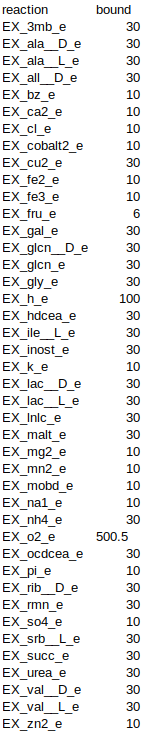 # AA7 medium that leads to 1.57 growth

In [569]:
growth_val = test_medium(AA7, combined_med)
growth_val

1.5735319340438343

In [616]:
growth_val = test_medium(AA3, combined_med)
growth_val

0.49008027474468596

In [617]:
with AA3:
    change_medium(AA3, combined_med)
    print(AA3.summary())

Objective
1.0 Growth = 0.49008027474469024

Uptake
------
Metabolite     Reaction      Flux  C-Number C-Flux
     ca2_e     EX_ca2_e  0.002551         0  0.00%
      cl_e      EX_cl_e  0.002551         0  0.00%
 cobalt2_e EX_cobalt2_e 4.901E-05         0  0.00%
     cu2_e     EX_cu2_e 0.0003475         0  0.00%
     fe2_e     EX_fe2_e  0.003291         0  0.00%
     fe3_e     EX_fe3_e  0.003827         0  0.00%
     gly_e     EX_gly_e     403.8         2  8.31%
  ile__L_e  EX_ile__L_e    0.1524         6  0.01%
       k_e       EX_k_e   0.09566         0  0.00%
  lac__L_e  EX_lac__L_e       600         3 18.52%
    malt_e    EX_malt_e     445.3        12 54.97%
     mg2_e     EX_mg2_e  0.004251         0  0.00%
     mn2_e     EX_mn2_e 0.0003386         0  0.00%
      o2_e      EX_o2_e       600         0  0.00%
      pi_e      EX_pi_e    0.6881         0  0.00%
     so4_e     EX_so4_e    0.1228         0  0.00%
  val__L_e  EX_val__L_e     353.8         5 18.19%
     zn2_e     EX_zn2_e 

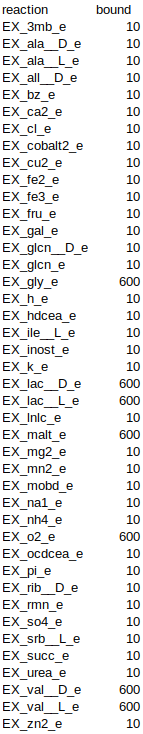 # AA3 medium leading to ~0.5 growth

In [166]:
get_met_unknown(models_curation, "bz_p")

bz_p (Benzoate (C7H5O2, -1)) is found  models: ['AA1', 'AA2', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'BZt1pp', 'BZt2_pp', 'BZtex'}


In [165]:
groww = test_medium(AA3, combined_med)

In [160]:
groww

# Blocked reactions (& Dead Ends)

In [13]:
# from memote
blocked_aa7 = ["EX_apc_e","EX_cd2_e","EX_cm_e","EX_cro4_e","EX_h2_e","EX_m_xyl_e","EX_na1_e","EX_ni2_e","EX_novbcn_e","EX_p_xyl_e","EX_pac_e","EX_tol_e","EX_ttrcyc_e","EX_uri_e","13PPDH","ACLS_d","ACNPLYS","ACOXT","ADNtex","BTDD_RR","CEPA","CLtex","H2tex","NI2tex","PACt1","PTAr","PUNP1","RECOAH20","RECOAH7","RECOAH8","UAG2EMA","URItex","XYLI1"]

In [41]:
with AA7:
    #change_medium(AA7, medium_mre_m9)
    aa7_fva = flux_variability_analysis(AA7)

In [229]:
find_blocked_reactions(AA7)

['EX_apc_e',
 'EX_cd2_e',
 'EX_cm_e',
 'EX_cro4_e',
 'EX_h2_e',
 'EX_m_xyl_e',
 'EX_na1_e',
 'EX_ni2_e',
 'EX_novbcn_e',
 'EX_p_xyl_e',
 'EX_pac_e',
 'EX_tol_e',
 'EX_ttrcyc_e',
 'EX_uri_e',
 '13PPDH',
 'ACLS_d',
 'ACNPLYS',
 'ACOXT',
 'ADNtex',
 'BTDD_RR',
 'CEPA',
 'CLtex',
 'H2tex',
 'NI2tex',
 'PACt1',
 'PTAr',
 'PUNP1',
 'RECOAH20',
 'RECOAH7',
 'RECOAH8',
 'UAG2EMA',
 'URItex',
 'XYLI1']

In [297]:
for met in AA7.metabolites:
    if (len(met.reactions)) <= 1:
        print(met)

13ppd_c
3hppnl_c
acnam_c
actp_c
adn_p
btd_RR_c
cellb_c
cl_p
h2_p
hethmpp_c
oxalcoa_c
pac_p
r1p_c
uri_p
xyl__D_c
xylu__D_c


In [298]:
for met in AA7.metabolites:
    if (len(met.reactions)) <= 1:
        rxn = [rxn.id for rxn in met.reactions]
        if len(AA7.metabolites.query(f"^{met.id[:-1]}")) == 1:
            print("isolated metabolite:", met.id, "with rxn", rxn)
        else:
            print("metabolite in other compartments: ", met.id, "with rxn", rxn)

isolated metabolite: 13ppd_c with rxn ['13PPDH']
isolated metabolite: 3hppnl_c with rxn ['13PPDH']
isolated metabolite: acnam_c with rxn ['ACNPLYS']
isolated metabolite: actp_c with rxn ['PTAr']
metabolite in other compartments:  adn_p with rxn ['ADNtex']
isolated metabolite: btd_RR_c with rxn ['BTDD_RR']
metabolite in other compartments:  cellb_c with rxn ['CEPA']
metabolite in other compartments:  cl_p with rxn ['CLtex']
metabolite in other compartments:  h2_p with rxn ['H2tex']
isolated metabolite: hethmpp_c with rxn ['ACLS_d']
isolated metabolite: oxalcoa_c with rxn ['ACOXT']
metabolite in other compartments:  pac_p with rxn ['PACt1']
isolated metabolite: r1p_c with rxn ['PUNP1']
metabolite in other compartments:  uri_p with rxn ['URItex']
isolated metabolite: xyl__D_c with rxn ['XYLI1']
isolated metabolite: xylu__D_c with rxn ['XYLI1']


## get network visualisation

In [2]:
from pyvis.network import Network

def visualise_network(model, rxn_list, file_name):
    rxns = set(rxn_list) # specify list of reactions that you want to visualise, e.g. ["rxn1", "rxn2", ...]
    net = Network(height="700px", width="100%", notebook=True, directed=True)

    for rxn in model.reactions:
        if rxn.id in rxns:
            # Add reactants → reaction node
            for met in rxn.reactants:
                net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_node(rxn.id, label=rxn.id, color="red", shape="box")
                net.add_edge(met.id, rxn.id, color='black') # reactant edges
            # Add reaction node → products
            for met in rxn.products:
                net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_edge(rxn.id, met.id, color='black') # product edges

    # this file is exported and then can be opened and examined your browser)
    net.show(file_name)
    print(f"File saved as {file_name}")


In [34]:
def get_colors(rxn_id, main_mets, rxn_list, node_type="reaction"):
    """ Return colors based on whether reaction/metabolite is blocked or expanded """
    if node_type == "reaction":
        if rxn_id in rxn_list:
            #return "red"
            return "yellowgreen"
        else:
            return "gray"
    elif node_type == "metabolite":
        # If metabolite is part of blocked reactions, color blue else gray
        # We'll decide by presence in main_mets (from blocked reactions)
        if rxn_id in main_mets:
            # return "lightblue"
            return "darkorange"
        else:
            return "lightgray"

def visualise_extended_network(model, rxn_list, file_name):
    rxns = set(rxn_list)

    # Metabolites to ignore as cofactors/currencies
    ignored_mets = {
        "h2o_c", "h_c", "h_e", "pi_c", "ppi_c", "co2_c",
        "nadh_c", "nad_c", "fadh2_c", "fad_c", "atp_c", "adp_c",
        "amp_c", "nadph_c", "nadp_c", "coa_c", "coa_e"
    }

    # Step 1: Collect main metabolites from blocked reactions
    main_mets = set()
    for rxn in model.reactions:
        if rxn.id in rxns:
            for met in rxn.reactants + rxn.products:
                if met.id not in ignored_mets:
                    main_mets.add(met.id)

    # Step 2: Add all reactions involving these main metabolites (expansion)
    expanded_rxns = set()
    for met_id in main_mets:
        met = model.metabolites.get_by_id(met_id)
        for rxn in met.reactions:
            expanded_rxns.add(rxn.id)

    # Only keep those reactions that are not in the original blocked list (to color differently)
    expanded_rxns = set(expanded_rxns) - set(rxn_list)

    # Combine all reactions
    all_rxns = set(rxn_list).union(set(expanded_rxns))

    # Step 3: Create pyvis network
    net = Network(height="700px", width="100%", notebook=False, directed=True)

    # Step 4: Add nodes and edges with direction/color based on reaction bounds and coloring scheme
    for rxn in model.reactions:
        if rxn.id not in all_rxns:
            continue

        # Reaction node
        rxn_color = get_colors(rxn.id, main_mets, rxn_list, node_type="reaction")
        net.add_node(rxn.id, label=rxn.id, color=rxn_color, shape="box")

        reversible = rxn.lower_bound < 0 and rxn.upper_bound > 0
        forward_only = rxn.lower_bound >= 0 and rxn.upper_bound > 0
        backward_only = rxn.upper_bound <= 0 and rxn.lower_bound < 0

        # Reactants edges and nodes
        for met in rxn.reactants:
            if met.id in ignored_mets:
                continue

            met_color = get_colors(met.id, main_mets, rxn_list, node_type="metabolite")
            net.add_node(met.id, label=met.id, color=met_color, shape="ellipse")

            if reversible:
                edge_color = "gold" if rxn.id in rxn_list else "lightgray"
                net.add_edge(met.id, rxn.id, color=edge_color, arrows="to,from")
            elif forward_only:
                edge_color = "black" if rxn.id in rxn_list else "lightgray"
                net.add_edge(met.id, rxn.id, color=edge_color, arrows="to")
            elif backward_only:
                edge_color = "gray" if rxn.id in rxn_list else "lightgray"
                net.add_edge(rxn.id, met.id, color=edge_color, arrows="to")

        # Products edges and nodes
        for met in rxn.products:
            if met.id in ignored_mets:
                continue

            met_color = get_colors(met.id, main_mets, rxn_list, node_type="metabolite")
            net.add_node(met.id, label=met.id, color=met_color, shape="ellipse")

            if reversible:
                edge_color = "gold" if rxn.id in rxn_list else "lightgray"
                net.add_edge(rxn.id, met.id, color=edge_color, arrows="to,from")
            elif forward_only:
                edge_color = "black" if rxn.id in rxn_list else "lightgray"
                net.add_edge(rxn.id, met.id, color=edge_color, arrows="to")
            elif backward_only:
                edge_color = "gray" if rxn.id in rxn_list else "lightgray"
                net.add_edge(met.id, rxn.id, color=edge_color, arrows="to")

    # Step 5: this file is exported and then can be opened and examined your browser)
    net.show(file_name, notebook=False)
    print(f"File saved.")


In [26]:
visualise_extended_network(AA7, blocked_aa7, "AA7_extended_blocked_reactions.html")

AA7_extended_blocked_reactions.html
File saved.


In [30]:
def visualise_extended_network_with_pfba(model, reaction_list, filename="network.html", scaling_factor=2.5):
    """
    Visualizes a reaction network with pyvis. The input list of reactions will be extended by adding
    all reactions that share main metabolites (excluding side metabolites).

    Parameters:
        model: cobra.Model
            The COBRApy model.
        reaction_list: list of str
            List of reaction IDs to use as a starting point.
        filename: str
            Name of the HTML file to export.
        scaling_factor: float
            Scales the arrow thickness according to flux values (log-based).
    """
    ignore_mets = {
        "h2o_c", "h_c", "h_e", "pi_c", "ppi_c", "co2_c",
        "nadh_c", "nad_c", "fadh2_c", "fad_c", "atp_c", "adp_c",
        "amp_c", "nadph_c", "nadp_c", "coa_c", "coa_e"
    }

    # Use parsimonious FBA instead of classical FBA
    solution = pfba(model)
    flux_dict = solution.fluxes.to_dict()

    # Compute flux range for normalization
    flux_values = [abs(flux) for flux in flux_dict.values() if abs(flux) > 1e-6]
    if flux_values:
        norm = mcolors.LogNorm(vmin=min(flux_values), vmax=max(flux_values))
    else:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap("Reds")

    def get_flux_color(flux):
        if abs(flux) < 1e-6:
            return "gray"
        rgba = cmap(norm(abs(flux)))
        return mcolors.to_hex(rgba)

    # Step 1: Extend the list of reactions
    extended_rxns = set(reaction_list)
    for rxn_id in reaction_list:
        rxn = model.reactions.get_by_id(rxn_id)
        for met in rxn.metabolites:
            if met.id in ignore_mets:
                continue
            for rxn2 in met.reactions:
                extended_rxns.add(rxn2.id)

    # Step 2: Initialize pyvis network
    net = Network(height="800px", width="100%", notebook=True, directed=True)
    net.set_options("""
    var options = {
      "nodes": {
        "font": {"size": 16},
        "scaling": {"min": 10, "max": 30}
      },
      "edges": {
        "scaling": {
          "min": 1,
          "max": 20,
          "label": true
        },
        "arrows": {
          "to": {"enabled": true}
        },
        "color": {"inherit": false}
      },
      "physics": {
        "stabilization": true
      }
    }
    """)

    for rxn_id in extended_rxns:
        rxn = model.reactions.get_by_id(rxn_id)
        flux = flux_dict.get(rxn_id, 0.0)

        # Logarithmic scaling for edge width
        if abs(flux) > 1e-6:
            width = min(max(np.log10(abs(flux) + 1) * scaling_factor, 1.5), 15.0)
        else:
            width = 1.0

        edge_color = get_flux_color(flux)
        node_color = "red" if rxn_id in reaction_list else "lightgray"

        net.add_node(rxn.id, label=rxn.id, color=node_color, shape="box")

        for reactant in rxn.reactants:
            if reactant.id in ignore_mets:
                continue
            net.add_node(reactant.id, label=reactant.id, color="lightblue", shape="ellipse")
            net.add_edge(reactant.id, rxn.id, color=edge_color, arrows="to", width=width)

        for product in rxn.products:
            if product.id in ignore_mets:
                continue
            net.add_node(product.id, label=product.id, color="lightblue", shape="ellipse")
            net.add_edge(rxn.id, product.id, color=edge_color, arrows="to", width=width)

    # Step 3: Show and export
    net.show(filename)


In [268]:
visualise_extended_network_with_pfba(AA7, blocked_aa7, "AA7_pfba_blocked_reactions.html")

AA7_pfba_blocked_reactions.html


/tmp/ipykernel_31714/3315229366.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


## some more visualisations

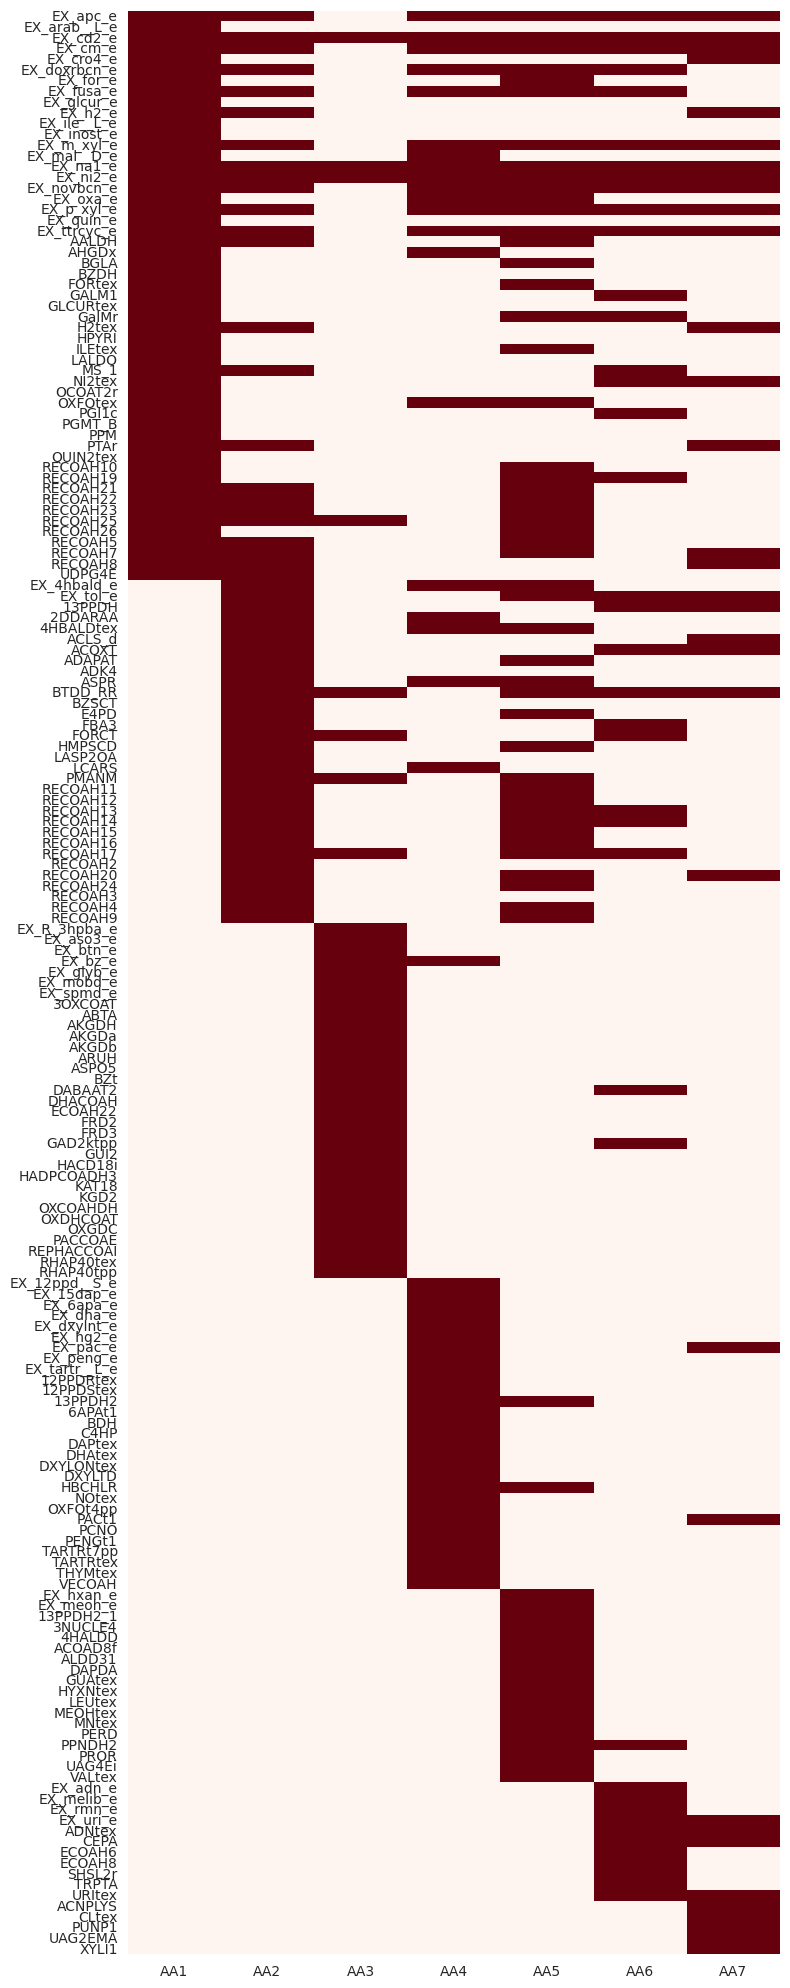

In [27]:
blocked_dict = {}
for name, model in models_curation.items():
    blocked = find_blocked_reactions(model)
    blocked_dict[name] = {rxn_id: True for rxn_id in blocked}

df = pd.DataFrame(blocked_dict).fillna(False)

plt.figure(figsize=(8, 20))  # width x height in inches, adjust height as needed
sns.heatmap(df, cmap="Reds", cbar=False, yticklabels=True)

plt.tight_layout()
plt.show()


In [25]:
df

,AA1,AA2,AA3,AA4,AA5,AA6,AA7
EX_apc_e,True,True,False,True,True,True,True
EX_arab__L_e,True,False,False,False,False,False,False
EX_cd2_e,True,True,True,True,True,True,True
EX_cm_e,True,True,False,True,True,True,True
EX_cro4_e,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...
ACNPLYS,False,False,False,False,False,False,True
CLtex,False,False,False,False,False,False,True
PUNP1,False,False,False,False,False,False,True
UAG2EMA,False,False,False,False,False,False,True


In [36]:
ecoli_fva = flux_variability_analysis(ecoli)

In [65]:
pseudo_fva = flux_variability_analysis(pseudo)

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [38]:
origins = pd.read_csv("../Datasets/BIGG/reactions_bigg_model_origin.csv")

In [39]:
origins

,bigg_id,name,bigg_models
0,11DOCRTSTRNtm,11-deoxycorticosterone intracellular transport,"['Recon3D', 'iMM1415', 'iCHOv1', 'RECON1', 'iC..."
1,10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal","['Recon3D', 'iMM1415', 'iCHOv1', 'RECON1', 'iC..."
2,11DOCRTSTRNtr,11-deoxycorticosterone intracellular transport,"['Recon3D', 'iMM1415', 'iCHOv1', 'RECON1', 'iC..."
3,10FTHFtm,10-Formyltetrahydrofolate mitochondrial transp...,"['Recon3D', 'iMM1415', 'iCHOv1', 'RECON1', 'iC..."
4,10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal","['Recon3D', 'iMM1415', 'iCHOv1', 'iAT_PLT_636'..."
...,...,...,...
28297,ZYMSTESTH_SCe,Zymosterol ester hydrolase yeast specific ex...,['iMM904']
28298,ZYMSTR,Zymosterol reductase,['iRC1080']
28299,ZYMSTt,Zymosterol reversible transport,"['iMM904', 'iND750']"
28300,Zn2tex,Zinc (Zn+2) transport via diffusion (extracell...,"['iECO103_1326', 'iE2348C_1286', 'iEC1344_C', ..."


In [52]:
blocked_models = []
for rxn in blocked_aa7:
    model_info = origins.loc[origins["bigg_id"] == rxn, "bigg_models"].iloc[0]

    blocked_models.append(model_info)

df_blocked = pd.DataFrame({
    'blocked_aa7': blocked_aa7,
    'blocked_models': blocked_models
})

In [53]:
df_blocked

,blocked_aa7,blocked_models
0,EX_apc_e,['iJN1463']
1,EX_cd2_e,"['iECO103_1326', 'iAF692', 'iE2348C_1286', 'iE..."
2,EX_cm_e,"['iECO103_1326', 'iE2348C_1286', 'iEC1344_C', ..."
3,EX_cro4_e,"['iJN1463', 'iYO844', 'iAF987']"
4,EX_h2_e,"['iSSON_1240', 'iG2583_1286', 'iYS1720', 'iSBO..."
5,EX_m_xyl_e,"['iJN746', 'iJN1463']"
6,EX_na1_e,"['iSSON_1240', 'iG2583_1286', 'iYS1720', 'iSBO..."
7,EX_ni2_e,"['iSSON_1240', 'iG2583_1286', 'iYS1720', 'iSBO..."
8,EX_novbcn_e,"['iECO103_1326', 'iE2348C_1286', 'iEC1344_C', ..."
9,EX_p_xyl_e,"['iJN746', 'iJN1463']"


In [61]:
df_blocked.to_csv("blocked_reactions_AA7.csv")

/tmp/ipykernel_31714/3535725073.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='blocked_models', data=df_exploded, order=df_exploded['blocked_models'].value_counts().index, palette='viridis')


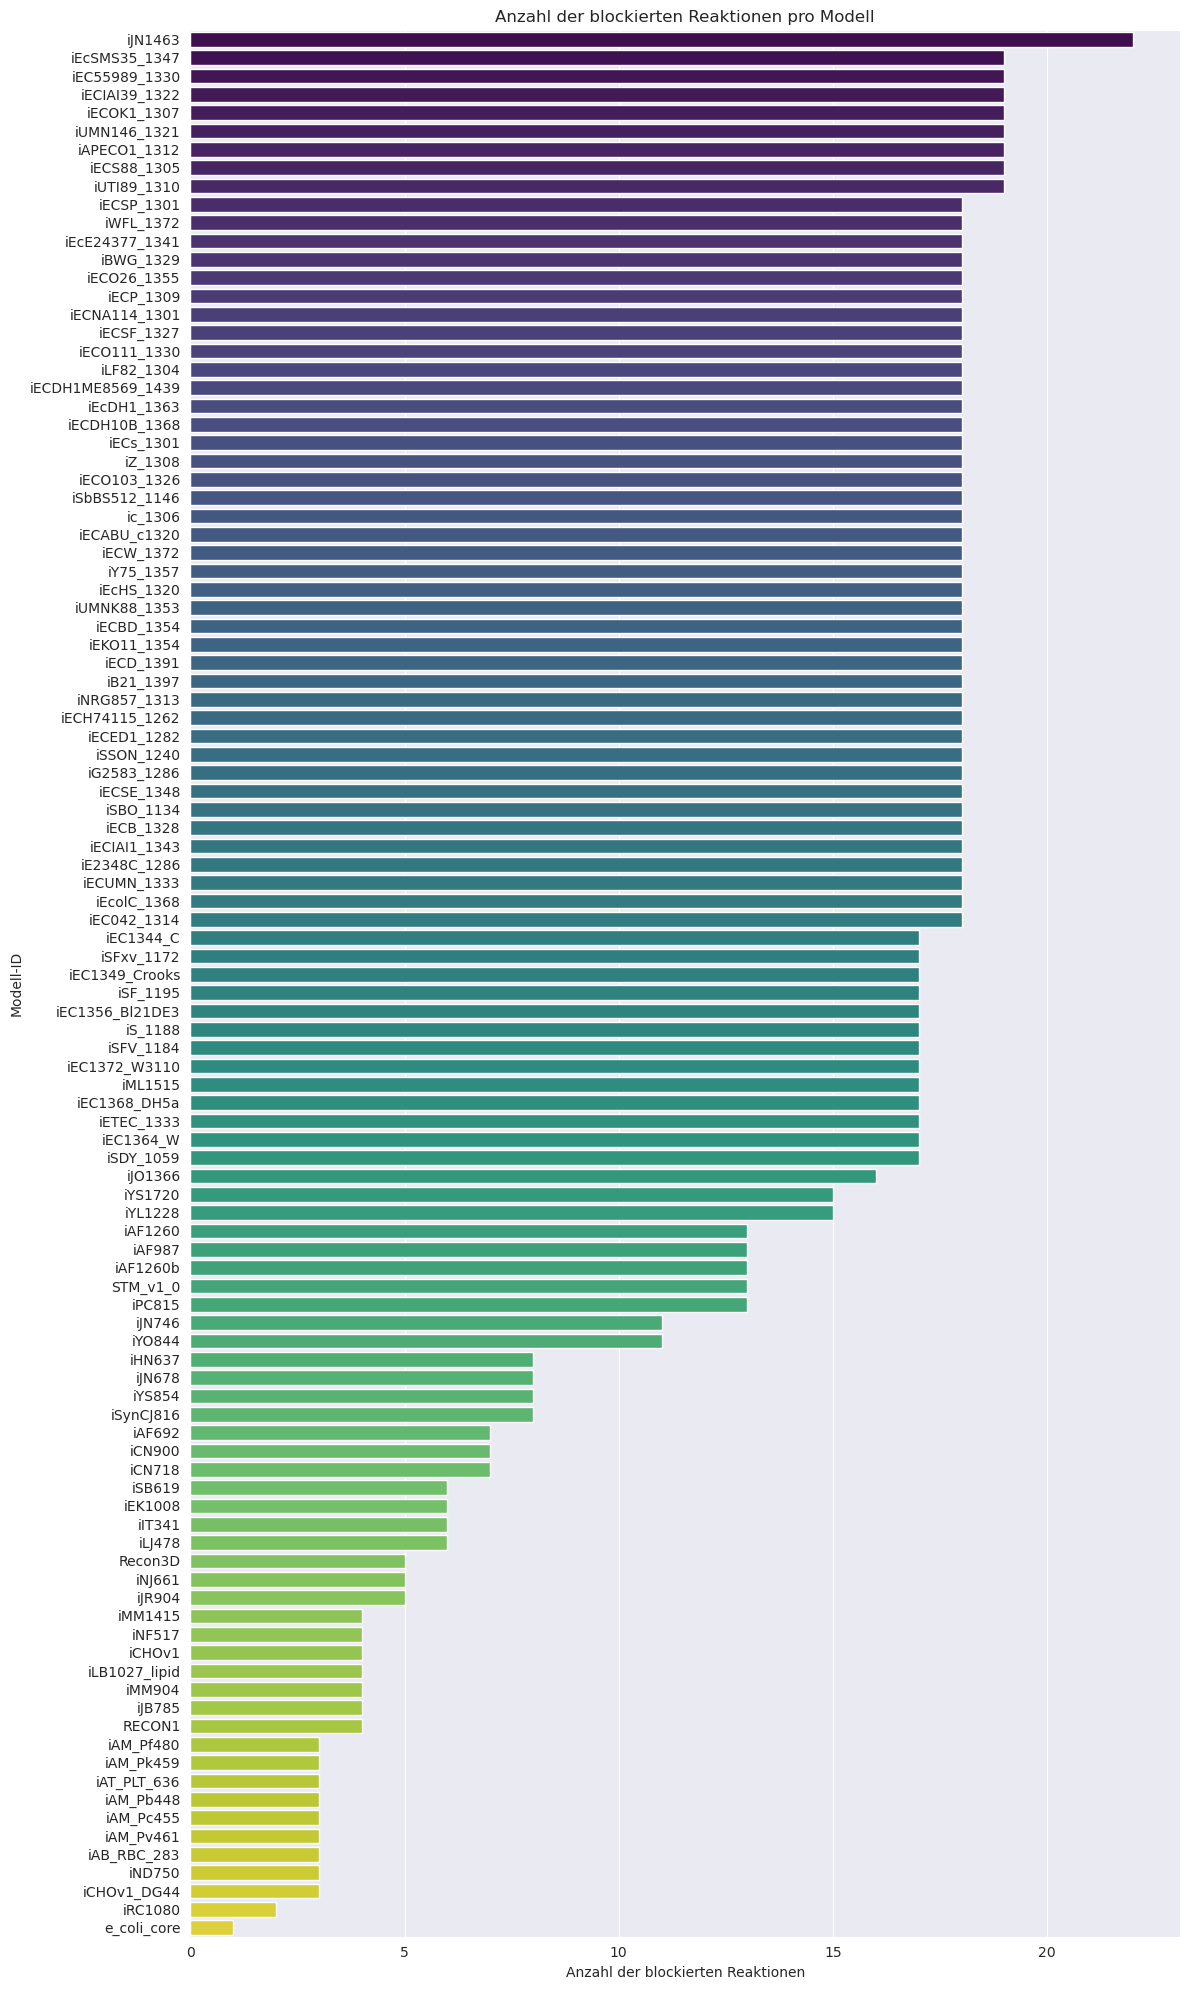

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Annahme: df_blocked ist Ihr DataFrame
# df_blocked = pd.DataFrame({'blocked_aa7': blocked_aa7, 'blocked_models': blocked_models})

# Schritt 1: Sicherstellen, dass die 'blocked_models'-Spalte Listen und keine Strings von Listen sind
# Wenn Ihre Daten bereits Listen sind, können Sie diesen Schritt überspringen.
# Wenn es sich um Strings wie "['AA1', 'AA2']" handelt, konvertiert dies sie in echte Listen.
try:
    df_blocked['blocked_models'] = df_blocked['blocked_models'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
except (ValueError, SyntaxError):
    print("Konvertierung der 'blocked_models'-Spalte nicht erforderlich oder fehlgeschlagen. Fährt mit den Daten fort, wie sie sind.")


# Schritt 2: 'Explodieren' Sie den DataFrame, sodass jede Reaktion-Modell-Paarung eine eigene Zeile hat
df_exploded = df_blocked.explode('blocked_models')

# Schritt 3: Erstellen Sie das Balkendiagramm
plt.figure(figsize=(12, 20))
sns.countplot(y='blocked_models', data=df_exploded, order=df_exploded['blocked_models'].value_counts().index, palette='viridis')
plt.title('Anzahl der blockierten Reaktionen pro Modell')
plt.xlabel('Anzahl der blockierten Reaktionen')
plt.ylabel('Modell-ID')
plt.tight_layout()
plt.show()


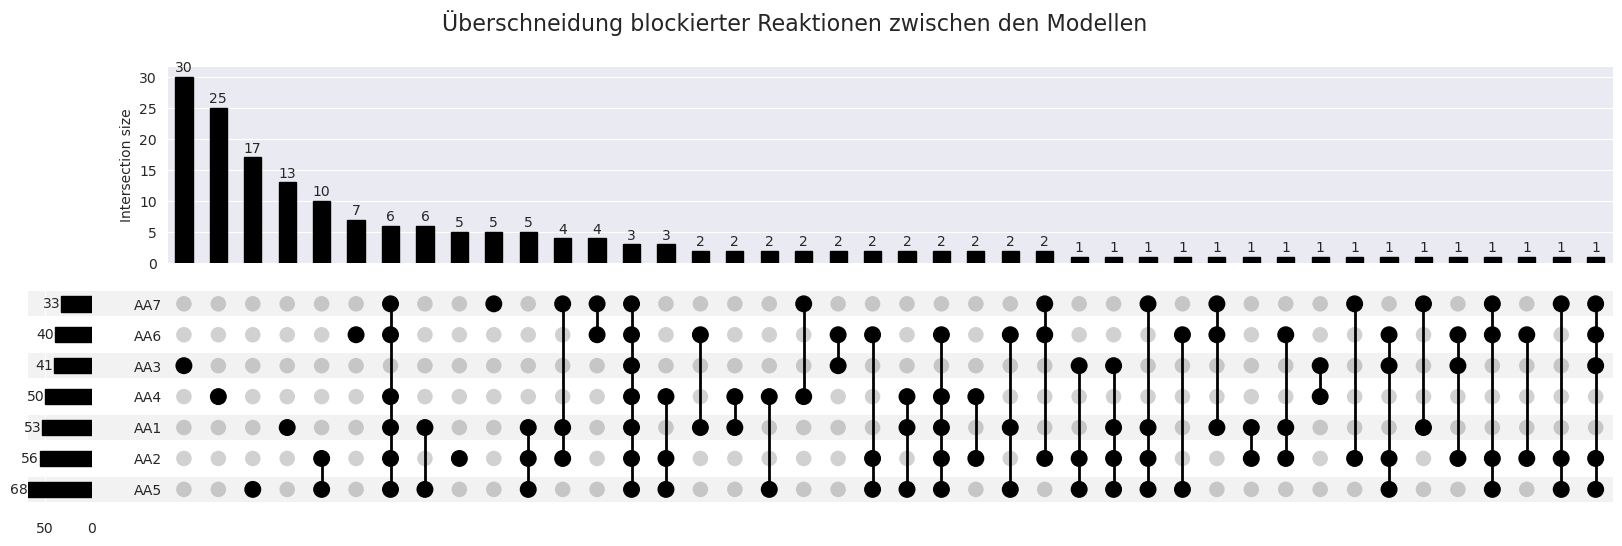

In [60]:
from upsetplot import UpSet, from_contents

# 1. Blockierte Reaktionen für jedes Modell finden und in einem Dictionary speichern
blocked_reactions_per_model = {}
for model_id, model in models_curation.items():
    # Die Funktion find_blocked_reactions gibt eine Liste der IDs blockierter Reaktionen zurück
    blocked_reactions = find_blocked_reactions(model)
    blocked_reactions_per_model[model_id] = set(blocked_reactions)

# 2. Die Daten in das für den Upset-Plot erforderliche Format konvertieren
upset_data_blocked = from_contents(blocked_reactions_per_model)

# 3. Die Figur für den Plot vorbereiten
fig_blocked = plt.figure(figsize=(15, 8))

# 4. Den Upset-Plot erstellen
upset_plot_blocked = UpSet(upset_data_blocked,
                           subset_size='count',
                           show_counts=True,
                           sort_by='cardinality') # Sortiert nach der Größe der Schnittmengen

# 5. Den Plot rendern und einen Titel hinzufügen
upset_plot_blocked.plot(fig=fig_blocked)
plt.suptitle('Überschneidung blockierter Reaktionen zwischen den Modellen', fontsize=16)
plt.show()

# Gap-Filling AA1 & AA5
these models really does not like to grow. lets find reasons

## AA5

In [ ]:
# first thing: blocked reactions, especially those EX reactions

In [26]:
aa5_blocked = find_blocked_reactions(AA5)

In [35]:
visualise_extended_network(AA5, aa5_blocked, "AA5_extended_blocked_reactions.html")

AA5_extended_blocked_reactions.html
File saved.


In [41]:
for rxn_id in aa5_blocked:
    print(AA5.reactions.get_by_id(rxn_id))

EX_4hbald_e: 4hbald_e <=> 
EX_apc_e: apc_e <=> 
EX_cd2_e: cd2_e <=> 
EX_cm_e: cm_e <=> 
EX_doxrbcn_e: doxrbcn_e <=> 
EX_for_e: for_e <=> 
EX_fusa_e: fusa_e <=> 
EX_hxan_e: hxan_e <=> 
EX_m_xyl_e: m_xyl_e <=> 
EX_meoh_e: meoh_e <=> 
EX_na1_e: na1_e <=> 
EX_ni2_e: ni2_e <=> 
EX_novbcn_e: novbcn_e <=> 
EX_oxa_e: oxa_e <=> 
EX_p_xyl_e: p_xyl_e <=> 
EX_tol_e: tol_e <=> 
EX_ttrcyc_e: ttrcyc_e <=> 
13PPDH2: 3hppnl_c + h_c + nadph_c <=> 13ppd_c + nadp_c
13PPDH2_1: h_c + lald__L_c + nadph_c <=> 13ppd_c + nadp_c
3NUCLE4: 3gmp_c + h2o_c <=> gsn_c + pi_c
4HALDD: 4hoxpacd_c + h2o_c + nad_c <=> 4hphac_c + 2.0 h_c + nadh_c
4HBALDtex: 4hbald_e <=> 4hbald_p
AALDH: h_c + nadh_c + pacald_c <=> nad_c + pea_c
ACOAD8f: fad_c + stcoa_c <=> fadh2_c + od2coa_c
ADAPAT: glu__L_c + nal2a6o_c <=> akg_c + n6all26d_c
ALDD31: aacald_c + h2o_c + nad_c <=> gly_c + 2.0 h_c + nadh_c
ASPR: asp__D_c <=> asp__L_c
BGLA: cellb_c + h2o_c <=> 2.0 glc__D_c
BTDD_RR: btd_RR_c + nad_c <=> actn__R_c + h_c + nadh_c
DAPDA: h2o_c + n6a

In [83]:
get_met_unknown(models_curation, "hxan_c")

hxan_c (Hypoxanthine (C5H4N4O, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'PUNP6_1', 'HXANt2r', 'HYXNtpp', 'HXANt2pp', 'HXPRT', 'HXAND', 'PUNP6', 'PUNP5_1', 'ADD', 'PUNP5', 'INSH'}


In [95]:
aa4_fluxies = pfba(AA4).fluxes

In [102]:
get_met(AA4, "hxan_p")

Hypoxanthine (C5H4N4O)
{'HYXNtex': 'hxan_e <=> hxan_p', 'HXANt2pp': 'h_p + hxan_p --> h_c + hxan_c'}


In [110]:
get_met(AA5, "phthr_c")

O-Phospho-4-hydroxy-L-threonine (C4H8NO7P)
{'4HTHRS': 'h2o_c + phthr_c --> 4hthr_c + pi_c', 'PDX5PS': 'dxyl5p_c + nad_c + phthr_c --> co2_c + 2.0 h2o_c + h_c + nadh_c + pdx5p_c + pi_c', '4HTHRK': '4hthr_c + atp_c --> adp_c + h_c + phthr_c'}


In [31]:
get_rxn(AA5, "RECOAH5", GPR=True)

RECOAH5: R_3hddcoa_c <=> h2o_c + trans_dd2coa_c
{'R_3hddcoa_c': -4, 'h2o_c': 0, 'trans_dd2coa_c': -4}
WP_079240854_1


In [168]:
get_rxn(AA5, "E4PD", GPR=True)

E4PD: e4p_c + h2o_c + nad_c <=> 4per_c + 2.0 h_c + nadh_c
{'e4p_c': -2, 'h2o_c': 0, 'nad_c': -1, '4per_c': -3, 'h_c': 1, 'nadh_c': -2}
WP_034694859_1


In [174]:
get_met(AA5, "phthr_c")

O-Phospho-4-hydroxy-L-threonine (C4H8NO7P)
{'4HTHRS': 'h2o_c + phthr_c --> 4hthr_c + pi_c', 'PDX5PS': 'dxyl5p_c + nad_c + phthr_c --> co2_c + 2.0 h2o_c + h_c + nadh_c + pdx5p_c + pi_c', '4HTHRK': '4hthr_c + atp_c --> adp_c + h_c + phthr_c'}


### consistent model
Martina also suggested to try this function: consistent_model = cobra.flux_analysis.fastcc(model) \
--> FASTCC (Fast Consistency Check) is an algorithm for rapid and efficient consistency check in metabolic networks

In [111]:
from cobra.flux_analysis import fastcc

consistent_aa5 = fastcc(AA5)

In [113]:
AA5

Name,AA5
Memory address,77bdf24538e0
Number of metabolites,1446
Number of reactions,2107
Number of genes,824
Number of groups,0
Objective expression,1.0*Growth - 1.0*Growth_reverse_699ae
Compartments,"cytosol, periplasm, extracellular space"


In [112]:
consistent_aa5

Name,AA5
Memory address,77bdea0eada0
Number of metabolites,1373
Number of reactions,2033
Number of genes,815
Number of groups,0
Objective expression,1.0*Growth - 1.0*Growth_reverse_699ae
Compartments,"cytosol, periplasm, extracellular space"


In [115]:
aa5_rxns = [rxn.id for rxn in AA5.reactions]
aa5_mets = [met.id for met in AA5.metabolites]
aa5_con_rxns = [rxn.id for rxn in consistent_aa5.reactions]
aa5_con_mets = [met.id for met in consistent_aa5.metabolites]

In [116]:
set(aa5_rxns) - set(aa5_con_rxns)

{'13PPDH2',
 '13PPDH2_1',
 '3NUCLE4',
 '4HALDD',
 '4HBALDtex',
 'AALDH',
 'ACOAD8f',
 'ADAPAT',
 'AIRCr',
 'ALDD31',
 'ASPR',
 'BGLA',
 'BTDD_RR',
 'DAPDA',
 'E4PD',
 'EX_4hbald_e',
 'EX_apc_e',
 'EX_cd2_e',
 'EX_cgly_e',
 'EX_cm_e',
 'EX_doxrbcn_e',
 'EX_for_e',
 'EX_fusa_e',
 'EX_gal_e',
 'EX_hxan_e',
 'EX_m_xyl_e',
 'EX_meoh_e',
 'EX_na1_e',
 'EX_ni2_e',
 'EX_novbcn_e',
 'EX_oxa_e',
 'EX_p_xyl_e',
 'EX_ptrc_e',
 'EX_tol_e',
 'EX_ttrcyc_e',
 'FORtex',
 'GUAtex',
 'GalMr',
 'HBCHLR',
 'HMPSCD',
 'HYXNtex',
 'ILEtex',
 'LEUtex',
 'MEOHtex',
 'MNtex',
 'OXFOtex',
 'PERD',
 'PMANM',
 'PPNDH2',
 'PROR',
 'RECOAH10',
 'RECOAH11',
 'RECOAH12',
 'RECOAH13',
 'RECOAH14',
 'RECOAH15',
 'RECOAH16',
 'RECOAH17',
 'RECOAH19',
 'RECOAH20',
 'RECOAH21',
 'RECOAH22',
 'RECOAH23',
 'RECOAH24',
 'RECOAH25',
 'RECOAH26',
 'RECOAH4',
 'RECOAH5',
 'RECOAH7',
 'RECOAH9',
 'SULR_1',
 'TYRTA',
 'UAG4Ei',
 'VALtex'}

In [124]:
set(aa5_blocked) - (set(aa5_rxns) - set(aa5_con_rxns))

set()

In [125]:
(set(aa5_rxns) - set(aa5_con_rxns)) - set(aa5_blocked)

{'AIRCr', 'EX_cgly_e', 'EX_gal_e', 'EX_ptrc_e', 'SULR_1', 'TYRTA'}

In [118]:
set(aa5_mets) - set(aa5_con_mets)

{'13ppd_c',
 '3gmp_c',
 '3hbcoa__R_c',
 '3hppnl_c',
 '4atb2coa_c',
 '4hbald_e',
 '4hbald_p',
 '4hoxpacd_c',
 '4hphac_c',
 '4per_c',
 '6ath2coa_c',
 'R3hdec4coa_c',
 'R_3h4atbcoa_c',
 'R_3h6athcoa_c',
 'R_3hcddec5ecoa_c',
 'R_3hcmrs7ecoa_c',
 'R_3hdcoa_c',
 'R_3hdd6coa_c',
 'R_3hddcoa_c',
 'R_3hhdcoa_c',
 'R_3hhpcoa_c',
 'R_3hnonacoa_c',
 'R_3hpbcoa_c',
 'R_3hpdecacoa_c',
 'R_3hphpcoa_c',
 'R_3hphxacoa_c',
 'R_3hpnonacoa_c',
 'R_3hpoctacoa_c',
 'R_3hpptcoa_c',
 'R_3htd58coa_c',
 'R_3htd5coa_c',
 'aacald_c',
 'asp__D_c',
 'btd_RR_c',
 'cellb_c',
 'dd6_2_coa_c',
 'dde2coa_c',
 'dec4_2_coa_c',
 'for_e',
 'for_p',
 'glc__aD_c',
 'gua_p',
 'hmpscoa_c',
 'hp2coa_c',
 'hxan_e',
 'hxan_p',
 'ile__L_p',
 'leu__L_p',
 'meoh_e',
 'meoh_p',
 'mn2_p',
 'n6all26d_c',
 'nal2a6o_c',
 'nona2coa_c',
 'ohpb_c',
 'oxa_e',
 'oxa_p',
 'pb2coa_c',
 'pdca2coa_c',
 'pea_c',
 'php2coa_c',
 'phxa2coa_c',
 'pnona2coa_c',
 'pocta2coa_c',
 'ppt2coa_c',
 'pro__D_c',
 'prpncoa_c',
 'stcoa_c',
 'td58_2_coa_c',
 'tde2co

In [120]:
with consistent_aa5:
    growth_val = test_medium(consistent_aa5, medium_combined_krumbach)
    print(growth_val)

0.0


In [123]:
AA5.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
acgam1p_e,EX_acgam1p_e,4.422,8,0.45%
adn_e,EX_adn_e,8.336,10,1.07%
akg_e,EX_akg_e,733.6,5,46.87%
arg__L_e,EX_arg__L_e,13.84,6,1.06%
asn__L_e,EX_asn__L_e,11.28,4,0.58%
bz_e,EX_bz_e,0.00468,7,0.00%
ca2_e,EX_ca2_e,0.2436,0,0.00%
cl_e,EX_cl_e,0.2436,0,0.00%
cobalt2_e,EX_cobalt2_e,0.00468,0,0.00%
cu2_e,EX_cu2_e,0.03318,0,0.00%


In [122]:
consistent_aa5.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
acgam1p_e,EX_acgam1p_e,4.422,8,0.45%
adn_e,EX_adn_e,8.336,10,1.07%
akg_e,EX_akg_e,733.6,5,46.87%
arg__L_e,EX_arg__L_e,13.84,6,1.06%
asn__L_e,EX_asn__L_e,11.28,4,0.58%
bz_e,EX_bz_e,0.00468,7,0.00%
ca2_e,EX_ca2_e,0.2436,0,0.00%
cl_e,EX_cl_e,0.2436,0,0.00%
cobalt2_e,EX_cobalt2_e,0.00468,0,0.00%
cu2_e,EX_cu2_e,0.03318,0,0.00%


## Biomass sukzessive aufbauen

In [21]:
def check_every_biomass_component(model, medium_dict):
    rxn_id = "Growth_small"
    sad_mets = []

    growth_mets = model.reactions.Growth.metabolites
    for met, flux in growth_mets.items():
        if flux < 0: # only look at mets that are consumed
            #print(met)
            stoich = {met: flux}

            if rxn_id in model.reactions: # biomass test reaction is updated
                rxn = model.reactions.get_by_id(rxn_id)
                rxn.subtract_metabolites(rxn.metabolites)
                rxn.add_metabolites(stoich)
            else: # first time reaction is created
                new_rxn = Reaction(id=rxn_id, name="Biomass reaction", lower_bound=0, upper_bound=1000)
                new_rxn.add_metabolites(stoich)
                model.add_reactions([new_rxn])

            model.objective = rxn_id

            with model:
                change_medium(model, medium_dict)
                try:
                    pfba_flux = pfba(model)
                    if pfba_flux[rxn_id] == 0:
                        sad_mets.append(met.id)
                except Infeasible:
                    print("Cannot get result because pfba is infeasible")

    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        model.remove_reactions([rxn])

    print(sad_mets)

In [47]:
if isinstance(medium_combined_krumbach, pd.DataFrame):
    krumbach_loose = dict(zip(medium_combined_krumbach.reaction, medium_combined_krumbach.bound))

    krumbach_loose = {x: 1000 for x in krumbach_loose}

In [ ]:
for model in models_curation.values():
    print(model.id)
    check_every_biomass_component(model, krumbach_loose)
    print("-------------")

The above shows that AA3 can grow with the medium, so like no essential components are missing or rather the model is missing something. For AA3 it really just depends on the bounds i.e. the amount of substrates that are available.

In [246]:
for model in models_curation.values():
    print(model.id)
    check_every_biomass_component(model, medium_combined_krumbach)
    print("-------------")

AA1
['nad_c', 'nadp_c', 'sheme_c']
-------------
AA2
['thmpp_c']
-------------
AA3
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result

In [232]:
for model in models_curation.values():
    print(model.id)
    check_every_biomass_component(model, medium_combined_naveed)
    print("-------------")

AA1
['nad_c', 'nadp_c', 'pro__L_c', 'sheme_c']
-------------
AA2
['thmpp_c']
-------------
AA3
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Canno

In [55]:
for model in models_curation.values():
    print(model.id)
    check_every_biomass_component(model, medium_beck)
    print("-------------")

AA1
['nad_c', 'nadp_c', 'sheme_c']
-------------
AA2
[]
-------------
AA3
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because 

In [96]:
for model in models_filled.values():
    print(model.id)
    check_every_biomass_component(model, medium_combined_naveed)
    print("-------------")

AA1
['pro__L_c']
-------------
AA2
['thmpp_c']
-------------
AA3
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is i

In [97]:
for model in models_filled.values():
    print(model.id)
    check_every_biomass_component(model, medium_combined_krumbach)
    print("-------------")

AA1
[]
-------------
AA2
['thmpp_c']
-------------
AA3
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible


## kdo2lipid4
C06025 (KEGG ID)

In [52]:
AA5.metabolites.kdo2lipid4_c

Metabolite identifier,kdo2lipid4_c
Name,KDO(2)-lipid IV(A)
Memory address,0x7a467a6ef760
Formula,C84H148N2O37P2
Compartment,C_c
In 2 reaction(s),"MOAT2, K2L4Aabcpp"


In [53]:
AA5.metabolites.kdo2lipid4_p

Metabolite identifier,kdo2lipid4_p
Name,KDO(2)-lipid IV(A)
Memory address,0x7a467a6ef790
Formula,C84H148N2O37P2
Compartment,C_p
In 2 reaction(s),"Growth, K2L4Aabcpp"


In [61]:
get_met(AA5, "ckdo_c")

CMP-3-deoxy-D-manno-octulosonate (C17H24N3O15P)
{'KDOCT2': 'ctp_c + kdo_c --> ckdo_c + ppi_c', 'MOAT2': 'ckdo_c + kdolipid4_c --> cmp_c + h_c + kdo2lipid4_c', 'MOAT': 'ckdo_c + lipidA_c --> cmp_c + h_c + kdolipid4_c'}


In [60]:
get_met(AA5, "kdolipid4_c")

KDO-lipid IV(A) (C76H137N2O30P2)
{'MOAT2': 'ckdo_c + kdolipid4_c --> cmp_c + h_c + kdo2lipid4_c', 'MOAT': 'ckdo_c + lipidA_c --> cmp_c + h_c + kdolipid4_c'}


In [62]:
get_met(AA5, "kdolipid4_c")

KDO-lipid IV(A) (C76H137N2O30P2)
{'MOAT2': 'ckdo_c + kdolipid4_c --> cmp_c + h_c + kdo2lipid4_c', 'MOAT': 'ckdo_c + lipidA_c --> cmp_c + h_c + kdolipid4_c'}


In [63]:
get_met(AA5, "lipidA_c")

2,3,2'3'-Tetrakis(beta-hydroxymyristoyl)-D-glucosaminyl-1,6-beta-D-glucosamine 1,4'-bisphosphate (C68H126N2O23P2)
{'TDSK': 'atp_c + lipidAds_c --> adp_c + h_c + lipidA_c', 'MOAT': 'ckdo_c + lipidA_c --> cmp_c + h_c + kdolipid4_c'}


In [64]:
get_met(AA5, "lipidAds_c")

Lipid A Disaccharide (C68H127N2O20P)
{'LPADSS': 'lipidX_c + u23ga_c --> h_c + lipidAds_c + udp_c', 'TDSK': 'atp_c + lipidAds_c --> adp_c + h_c + lipidA_c'}


In [65]:
get_met(AA5, "u23ga_c")

UDP-2,3-bis(3-hydroxytetradecanoyl)glucosamine (C43H75N3O20P2)
{'LPADSS': 'lipidX_c + u23ga_c --> h_c + lipidAds_c + udp_c', 'U23GAAT': '3hmrsACP_c + u3hga_c --> ACP_c + h_c + u23ga_c', 'USHD': 'h2o_c + u23ga_c --> 2.0 h_c + lipidX_c + ump_c'}


In [67]:
get_met(AA5, "u3hga_c")

UDP-3-O-(3-hydroxytetradecanoyl)-D-glucosamine (C29H50N3O18P2)
{'UHGADA': 'h2o_c + u3aga_c --> ac_c + u3hga_c', 'U23GAAT': '3hmrsACP_c + u3hga_c --> ACP_c + h_c + u23ga_c'}


In [68]:
get_met(AA5, "u3aga_c")

UDP-3-O-(3-hydroxytetradecanoyl)-N-acetylglucosamine (C31H51N3O19P2)
{'UAGAAT': '3hmrsACP_c + uacgam_c <=> ACP_c + u3aga_c', 'UHGADA': 'h2o_c + u3aga_c --> ac_c + u3hga_c'}


In [83]:
def check_early_biomass_component(model, medium_dict, check_rxn_id):
    rxn_id = "objective_check"
    sad_mets = []

    check_mets = model.reactions.get_by_id(check_rxn_id).metabolites
    #check_mets = model.reactions.check_rxn_id.metabolites
    for met, flux in check_mets.items():
        if flux < 0: # only look at mets that are consumed
            #print(met)
            stoich = {met: flux}

            if rxn_id in model.reactions: # biomass test reaction is updated
                rxn = model.reactions.get_by_id(rxn_id)
                rxn.subtract_metabolites(rxn.metabolites)
                rxn.add_metabolites(stoich)
            else: # first time reaction is created
                new_rxn = Reaction(id=rxn_id, name="objective reaction", lower_bound=0, upper_bound=1000)
                new_rxn.add_metabolites(stoich)
                model.add_reactions([new_rxn])

            model.objective = rxn_id

            with model:
                change_medium(model, medium_dict)
                try:
                    pfba_flux = pfba(model)
                    if pfba_flux[rxn_id] == 0:
                        sad_mets.append(met.id)
                except Infeasible:
                    print("Cannot get result because pfba is infeasible")

    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        model.remove_reactions([rxn])

    print(sad_mets)

In [129]:
check_early_biomass_component(AA5, medium_combined_krumbach, "UAGAAT")

['citr__L_c']


In [69]:
get_met(AA5, "3hmrsACP_c")

(R)-3-Hydroxytetradecanoyl-[acyl-carrier protein] (C398H629N96O144PS3)
{'UAGAAT': '3hmrsACP_c + uacgam_c <=> ACP_c + u3aga_c', '3HAACOAT140': '3hmrsACP_c + coa_c <=> ACP_c + R_3hmrscoa_c', 'U23GAAT': '3hmrsACP_c + u3hga_c --> ACP_c + h_c + u23ga_c', '3HAD140': '3hmrsACP_c --> h2o_c + tmrs2eACP_c'}


In [79]:
get_met(AA5, "R_3hmrscoa_c")

(R)-3-hydroxytetradecanoyl-coa (C35H58N7O18P3S)
{'3HAACOAT140': '3hmrsACP_c + coa_c <=> ACP_c + R_3hmrscoa_c', 'RECOAH6': 'R_3hmrscoa_c <=> h2o_c + td2coa_c'}


In [80]:
get_met(AA5, "td2coa_c")

Trans-Tetradec-2-enoyl-CoA (C35H56N7O17P3S)
{'CTECOAI6': 'tdecoa_c <=> td2coa_c', 'ACOAD6f': 'fad_c + tdcoa_c <=> fadh2_c + td2coa_c', 'ECOAH6': '3htdcoa_c <=> h2o_c + td2coa_c', 'ACOAD6': 'nad_c + tdcoa_c <=> h_c + nadh_c + td2coa_c', 'RECOAH6': 'R_3hmrscoa_c <=> h2o_c + td2coa_c'}


In [70]:
get_met(AA5, "uacgam_c")

UDP-N-acetyl-D-glucosamine (C17H25N3O17P2)
{'UAGCVT': 'pep_c + uacgam_c --> pi_c + uaccg_c', 'UAGAAT': '3hmrsACP_c + uacgam_c <=> ACP_c + u3aga_c', 'UAGPT3': 'uacgam_c + uagmda_c --> h_c + uaagmda_c + udp_c', 'UAG4Ei': 'uacgam_c <=> udpacgal_c', 'UAGDP': 'acgam1p_c + h_c + utp_c --> ppi_c + uacgam_c'}


In [82]:
get_met(AA5, "acgam1p_c")

N-Acetyl-D-glucosamine 1-phosphate (C8H14NO9P)
{'UAGDP': 'acgam1p_c + h_c + utp_c --> ppi_c + uacgam_c', 'ACGAM1P_Et': 'acgam1p_e <=> acgam1p_c'}


In [87]:
get_met_unknown(models_curation, "gam6p_c")

gam6p_c (D-Glucosamine 6-phosphate (C6H13NO8P, -1)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'G6PDA', 'GAM6Pt', 'GAMptspp', 'GF6PTA', 'GAMpts', 'GAM6Pt6_2pp', 'PGAMT', 'AGDC'}


In [85]:
get_rxn_unknown(models_curation, "PGAMT")

PGAMT is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA6', 'AA7']
PGAMT: gam1p_c <=> gam6p_c
{'gam1p_c': -1, 'gam6p_c': -1}


In [95]:
get_rxn_unknown(models_curation, "G1PACT")

G1PACT is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
G1PACT: accoa_c + gam1p_c --> acgam1p_c + coa_c + h_c
{'gam1p_c': -1, 'accoa_c': -4, 'acgam1p_c': -2, 'coa_c': -4, 'h_c': 1}


## arginine

In [107]:
get_met(AA5, "arg__L_c")

L-Arginine (C6H15N4O2)
{'ARGt5r': 'arg__L_e <=> arg__L_c', 'ARGDC': 'arg__L_c + h_c --> agm_c + co2_c', 'ARGabc': 'arg__L_e + atp_c + h2o_c --> adp_c + arg__L_c + h_c + pi_c', 'ARGt2r': 'arg__L_e + h_e --> arg__L_c + h_c', 'ARGN': 'arg__L_c + h2o_c --> orn_c + urea_c', 'ARGSL': 'argsuc_c <=> arg__L_c + fum_c', 'Growth': ''}


In [110]:
get_met(AA5, "argsuc_c")

N(omega)-(L-Arginino)succinate (C10H17N4O6)
{'ARGSS': 'asp__L_c + atp_c + citr__L_c --> amp_c + argsuc_c + h_c + ppi_c', 'ARGSL': 'argsuc_c <=> arg__L_c + fum_c'}


In [132]:
get_met(AA5, "citr__L_c") # wird aus orn synthetisiert

L-Citrulline (C6H13N3O3)
{'objective_check': 'citr__L_c --> ', 'OCBT': 'cbp_c + orn_c <=> citr__L_c + h_c + pi_c', 'ARGSS': 'asp__L_c + atp_c + citr__L_c --> amp_c + argsuc_c + h_c + ppi_c'}


In [130]:
check_early_biomass_component(AA5, medium_combined_krumbach, "ARGSL") # argsuc wird aus citr gewonnen

['argsuc_c']


In [131]:
check_early_biomass_component(AA5, medium_combined_krumbach, "ARGSS")

['citr__L_c']


In [133]:
check_early_biomass_component(AA5, medium_combined_krumbach, "OCBT")

['orn_c']


In [135]:
get_met(AA5, "orn_c")

Ornithine (C5H13N2O2)
{'PTRCORNt7': 'orn_c + ptrc_e <=> orn_e + ptrc_c', 'ORNt': 'orn_e <=> orn_c', 'OCBT': 'cbp_c + orn_c <=> citr__L_c + h_c + pi_c', 'objective_check': 'orn_c --> ', 'ACODA': 'acorn_c + h2o_c --> ac_c + orn_c', 'ORNTA': 'akg_c + orn_c <=> glu5sa_c + glu__L_c', 'ARGN': 'arg__L_c + h2o_c --> orn_c + urea_c'}


In [136]:
get_met(AA5, "acorn_c")

N2-Acetyl-L-ornithine (C7H14N2O3)
{'ACOTA': 'acorn_c + akg_c <=> acg5sa_c + glu__L_c', 'ACODA': 'acorn_c + h2o_c --> ac_c + orn_c'}


In [137]:
check_early_biomass_component(AA5, medium_combined_krumbach, "ACOTA")

['acorn_c']


In [138]:
get_met(AA5, "acg5sa_c")

N-Acetyl-L-glutamate 5-semialdehyde (C7H10NO4)
{'AGPR': 'acg5sa_c + nadp_c + pi_c <=> acg5p_c + h_c + nadph_c', 'ACOTA': 'acorn_c + akg_c <=> acg5sa_c + glu__L_c'}


In [139]:
get_met(AA5, "acg5p_c")

N-Acetyl-L-glutamyl 5-phosphate (C7H9NO8P)
{'AGPR': 'acg5sa_c + nadp_c + pi_c <=> acg5p_c + h_c + nadph_c', 'ACGK': 'acglu_c + atp_c --> acg5p_c + adp_c'}


In [140]:
check_early_biomass_component(AA5, medium_combined_krumbach, "AGPR")

['acg5sa_c']


In [146]:

check_early_biomass_component(AA5, medium_combined_krumbach, "ACGK")

['acglu_c']


In [143]:
get_met_unknown(models_curation, "acg5p_c")

acg5p_c (N-Acetyl-L-glutamyl 5-phosphate (C7H9NO8P, -3)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'ACGK_1', 'AGPR', 'ACGK'}


In [145]:
get_met(AA5, "acglu_c")

N-Acetyl-L-glutamate (C7H9NO5)
{'ACGK': 'acglu_c + atp_c --> acg5p_c + adp_c', 'ACGLUtd': 'acglu_c <=> acglu_e'}


In [147]:
get_met_unknown(models_curation, "acglu_c")

acglu_c (N-Acetyl-L-glutamate (C7H9NO5, -2)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'ACGLUtd', 'ACGK', 'ORNTAC', 'ACGK_1', 'ORNTAC_1', 'ACGS'}


In [148]:
get_rxn_unknown(models_curation, "ORNTAC")

ORNTAC is found in: ['AA2', 'AA3', 'AA6']
ORNTAC: acorn_c + glu__L_c <=> acglu_c + orn_c
{'acorn_c': 0, 'glu__L_c': -1, 'acglu_c': -2, 'orn_c': 1}


In [150]:
get_rxn_unknown(models_curation, "ACGS")

ACGS is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA6', 'AA7']
ACGS: accoa_c + glu__L_c --> acglu_c + coa_c + h_c
{'accoa_c': -4, 'glu__L_c': -1, 'acglu_c': -2, 'coa_c': -4, 'h_c': 1}


## introduce changes to AA5

I should add PGAMT and G1PACT to AA5 \
https://biocyc.org/reaction?orgid=GCF_002025665&id=2.3.1.157-RXN this is G1PACT \
https://biocyc.org/reaction?orgid=GCF_002025665&id=5.4.2.10-RXN this is PGAMT \
according to Metacyc both should be in AA5

In [22]:
new_rxn = copy.deepcopy(AA1.reactions.G1PACT)
AA5.add_reactions([new_rxn])

new_rxn = copy.deepcopy(AA1.reactions.PGAMT)
AA5.add_reactions([new_rxn])

i should maybe add ACGS; there is howver no evidence that this should be in the model; according to KEGG not in AA5 and metacyc says only computationally inferred
https://biocyc.org/reaction?orgid=GCF_002025665&id=N-ACETYLTRANSFER-RXN#SUMMARY \
adding this reaction fixes the arginine AA5 problem!

In [23]:
new_rxn = copy.deepcopy(AA1.reactions.ACGS)
AA5.add_reactions([new_rxn])

In [24]:
AA5.objective = "Growth"

In [93]:
#write_sbml_model(AA5, "../Models/12_gap_filled/AA5_filled.xml") # more changes down below for boundaries

In [258]:
check_early_biomass_component(AA5f, medium_combined_krumbach, "Growth")

[]


## AA1
problems with nad and nadp, apparently they cannot be synthesized

### nad

In [154]:
get_met(AA1, "nad_c")

Nicotinamide adenine dinucleotide (C21H26N7O14P2)
{'HACD11i': '3hnonacoa_c + nad_c --> 3ononacoa_c + h_c + nadh_c', 'ME1': 'mal__L_c + nad_c --> co2_c + nadh_c + pyr_c', 'NADHPO': 'h2o2_c + h_c + nadh_c --> 2.0 h2o_c + nad_c', 'GLYALDDr': 'glyald_c + h2o_c + nad_c --> glyc__R_c + 2.0 h_c + nadh_c', 'OXPTNDH': 'h2o_c + nad_c + oxptn_c <=> glutar_c + 2.0 h_c + nadh_c', '4HBADH': '4hba_c + nad_c <=> 4hbald_c + h_c + nadh_c', 'COALCDH': 'confrl_c + nad_c --> conialdh_c + h_c + nadh_c', 'PDHcr': 'dhlam_c + nad_c --> h_c + lpam_c + nadh_c', 'GAPD': 'g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c', 'HACD3i': '3hocoa_c + nad_c --> 3oocoa_c + h_c + nadh_c', 'MMSAD3': 'coa_c + msa_c + nad_c --> accoa_c + co2_c + nadh_c', 'P5CD': '1pyr5c_c + 2.0 h2o_c + nad_c --> glu__L_c + h_c + nadh_c', 'PGCD': '3pg_c + nad_c --> 3php_c + h_c + nadh_c', 'HACD32i': '3hdd6coa_c + nad_c --> 3odd6coa_c + h_c + nadh_c', 'XAND': 'h2o_c + nad_c + xan_c --> h_c + nadh_c + urate_c', 'ALCD22_L': 'lald__L_c + nad_c <=> h

In [161]:
nad_rxns = []
for rxn in AA1.reactions:
    if AA1.metabolites.nad_c in rxn.metabolites.keys() and AA1.metabolites.nadh_c not in rxn.metabolites.keys():
        print(rxn.id)
        nad_rxns.append(rxn.id)
# get reactions where only nad is used and not nadh to prevent reactions where we only have recycling

GCVHADPr
NADDP
NADK
NADS1
NADS2
NMNAT
Growth


In [166]:
for rxn in nad_rxns:
    get_rxn(AA1, rxn, charge=False)
    print("-------")

GCVHADPr: gcvHL_nhLA_c + nad_c --> gcvHL_ADPr_c + ncam_c
-------
NADDP: h2o_c + nad_c --> amp_c + 2.0 h_c + nmn_c
-------
NADK: atp_c + nad_c --> adp_c + h_c + nadp_c
-------
NADS1: atp_c + dnad_c + nh4_c --> amp_c + h_c + nad_c + ppi_c
-------
NADS2: atp_c + dnad_c + gln__L_c + h2o_c --> amp_c + glu__L_c + h_c + nad_c + ppi_c
-------
NMNAT: atp_c + h_c + nmn_c --> nad_c + ppi_c
-------
Growth: 0.000223 10fthf_c + 0.513689 ala__L_c + 0.000223 amet_c + 0.295792 arg__L_c + 0.241055 asn__L_c + 0.241055 asp__L_c + 54.124831 atp_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 0.0001 cobalt2_c + 0.133508 ctp_c + 0.000709 cu2_c + 0.09158 cys__L_c + 0.026166 datp_c + 0.027017 dctp_c + 0.027017 dgtp_c + 0.026166 dttp_c + 0.000223 fad_c + 0.006715 fe2_c + 0.007808 fe3_c + 0.26316 gln__L_c + 0.26316 glu__L_c + 0.612638 gly_c + 0.215096 gtp_c + 48.601527 h2o_c + 0.094738 his__L_c + 0.290529 ile__L_c + 0.195193 k_c + 0.019456 kdo2lipid4_p + 0.450531 leu__L_c + 0.343161 lys__L_c + 0.153686 met

only NADS1, NADS2 and NMNAT produce NAD

In [167]:
get_met(AA1, "dnad_c")

Deamino-NAD+ (C21H24N6O15P2)
{'NADS2': 'atp_c + dnad_c + gln__L_c + h2o_c --> amp_c + glu__L_c + h_c + nad_c + ppi_c', 'DNADDP': 'dnad_c + h2o_c --> amp_c + 2.0 h_c + nicrnt_c', 'NNATr': 'atp_c + h_c + nicrnt_c --> dnad_c + ppi_c', 'NADS1': 'atp_c + dnad_c + nh4_c --> amp_c + h_c + nad_c + ppi_c'}


NADS2 6.3.5.1 \
NNATr 2.7.7.18

In [168]:
get_met(AA1, "nicrnt_c")

Nicotinate D-ribonucleotide (C11H12NO9P)
{'NMNDA': 'h2o_c + nmn_c --> nh4_c + nicrnt_c', 'DNADDP': 'dnad_c + h2o_c --> amp_c + 2.0 h_c + nicrnt_c', 'NNATr': 'atp_c + h_c + nicrnt_c --> dnad_c + ppi_c', 'NAPRT': 'h_c + nac_c + prpp_c --> nicrnt_c + ppi_c'}


NNDPR 2.4.2.19 - this reaction is missing in AA1 but present in the rest of the models \
https://biocyc.org/pathway?orgid=GCF_000072485&id=NADSYN-PWY \
according to KEGG not in model and Metacyc also only computer-inferred

In [170]:
get_met_unknown(models_curation, "nicrnt_c")

nicrnt_c (Nicotinate D-ribonucleotide (C11H12NO9P, -2)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'NNDPR', 'NT5C', 'NMNDA', 'NAPRT', 'NAMNPP', 'NNATr', 'DNADDP'}


In [171]:
get_rxn_unknown(models_curation, "NNDPR")

NNDPR is found in: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
NNDPR: 2.0 h_c + prpp_c + quln_c --> co2_c + nicrnt_c + ppi_c
{'h_c': 1, 'prpp_c': -5, 'quln_c': -2, 'co2_c': 0, 'nicrnt_c': -2, 'ppi_c': -3}


In [180]:
get_rxn_unknown(models_curation, "QULNS")

QULNS is found in: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
QULNS: dhap_c + iasp_c --> 2.0 h2o_c + pi_c + quln_c


QULNS 2.5.1.72

In [173]:
get_met(AA1, "quln_c")

No match.


In [174]:
get_met_unknown(models_curation, "quln_c")

quln_c (Quinolinate (C7H3NO4, -2)) is found  models: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'QULNS', 'NNDPR'}


In [217]:
get_rxn_unknown(models_curation, "QULNS")

QULNS is found in: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
QULNS: dhap_c + iasp_c --> 2.0 h2o_c + pi_c + quln_c


In [64]:
get_rxn_unknown(models_curation, "NNDPR")

NNDPR is found in: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
NNDPR: 2.0 h_c + prpp_c + quln_c --> co2_c + nicrnt_c + ppi_c


In [65]:
get_met(AA1, "nicrnt_c")

Nicotinate D-ribonucleotide (C11H12NO9P)
{'NMNDA': 'h2o_c + nmn_c --> nh4_c + nicrnt_c', 'DNADDP': 'dnad_c + h2o_c --> amp_c + 2.0 h_c + nicrnt_c', 'NNATr': 'atp_c + h_c + nicrnt_c --> dnad_c + ppi_c', 'NAPRT': 'h_c + nac_c + prpp_c --> nicrnt_c + ppi_c'}


In [218]:
get_met(AA1, "iasp_c")

No match.


In [66]:
get_met_unknown(models_curation, "iasp_c")

iasp_c (Iminoaspartate (C4H3NO4, -2)) is found  models: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'ASPO3', 'ASPO2y', 'ASPO5', 'ASPO2', 'QULNS', 'ASPO4', 'ASPO6'}


In [70]:
get_rxn_unknown(models_curation, "ASPO6")

ASPO6 is found in: ['AA2', 'AA3', 'AA4', 'AA6', 'AA7']
ASPO6: asp__L_c + o2_c --> h2o2_c + h_c + iasp_c


In [69]:
get_rxn_unknown(models_curation, "ASPO2y")

ASPO2y is found in: ['AA2', 'AA4', 'AA6']
ASPO2y: asp__L_c + nadp_c --> 2.0 h_c + iasp_c + nadph_c


In [67]:
get_rxn_unknown(models_curation, "NAMNPP") # R01724, 6.3.4.21 (KEGG says yes, Metacyc says only computer-inferred)

ASPO3 is found in: ['AA3', 'AA4', 'AA6', 'AA7']
ASPO3: asp__L_c + q8_c --> h_c + iasp_c + q8h2_c


In [190]:
get_met(AA1, "nac_c")

Nicotinate (C6H4NO2)
{'NNAM': 'h2o_c + ncam_c --> nac_c + nh4_c', 'NAPRT': 'h_c + nac_c + prpp_c --> nicrnt_c + ppi_c'}


In [197]:
get_met(AA1, "ncam_c")

Nicotinamide (C6H6N2O)
{'objective_check': 'ncam_c --> ', 'NNAM': 'h2o_c + ncam_c --> nac_c + nh4_c', 'GCVHADPr': 'gcvHL_nhLA_c + nad_c --> gcvHL_ADPr_c + ncam_c'}


In [189]:
get_met_unknown(models_curation, "ncam_c")

ncam_c (Nicotinamide (C6H6N2O, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA7'] and in reactions: {'NMNN', 'PNP_1', 'NADN', 'NNAM', 'GCVHADPr', 'NMNS', 'PNP'}


In [203]:
get_rxn_unknown(models_curation, "NMNN")

NMNN is found in: ['AA2', 'AA7']
NMNN: h2o_c + nmn_c --> h_c + ncam_c + r5p_c


In [204]:
get_met_unknown(models_curation, "nmn_c")

nmn_c (NMN C11H14N2O8P (C11H14N2O8P, -1)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'NMNN', 'NADDP', 'NMNHYD', 'NADDPp_1', 'NMNPtpp', 'RNMK', 'NMNDA', 'NMNS', 'NMNP', 'NMNAT'}


In [205]:
get_met(AA1, "nmn_c")

NMN C11H14N2O8P (C11H14N2O8P)
{'NMNAT': 'atp_c + h_c + nmn_c --> nad_c + ppi_c', 'NMNDA': 'h2o_c + nmn_c --> nh4_c + nicrnt_c', 'NADDP': 'h2o_c + nad_c --> amp_c + 2.0 h_c + nmn_c', 'NMNP': 'nmn_e --> nmn_c'}


In [225]:
get_rxn_unknown(models_curation, "NADDP")

NADDP is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
NADDP: h2o_c + nad_c --> amp_c + 2.0 h_c + nmn_c


In [207]:
check_early_biomass_component(AA1, medium_combined_krumbach, "NNAM")

['ncam_c']


In [201]:
get_met(AA1, "gcvHL_ADPr_c")

N-Lipoyl ADP-ribose gcvh-L protein (C23H36N6O21P4S2)
{'objective_check': 'gcvHL_ADPr_c --> ', 'GCVHRADPr': 'gcvHL_ADPr_c + h2o_c --> adprib_c + gcvHL_nhLA_c + h_c', 'GCVHADPr': 'gcvHL_nhLA_c + nad_c --> gcvHL_ADPr_c + ncam_c'}


In [202]:
get_met(AA1, "gcvHL_nhLA_c")

N-Lipoyl gcvh-L protein (C8H16NO8P2S2)
{'GCVHRADPr': 'gcvHL_ADPr_c + h2o_c --> adprib_c + gcvHL_nhLA_c + h_c', 'GCVHADPr': 'gcvHL_nhLA_c + nad_c --> gcvHL_ADPr_c + ncam_c'}


### nadp

In [219]:
nadp_rxns = []
for rxn in AA1.reactions:
    if AA1.metabolites.nadp_c in rxn.metabolites.keys() and AA1.metabolites.nadph_c not in rxn.metabolites.keys():
        print(rxn.id)
        nadp_rxns.append(rxn.id)
# get reactions where only nadp is used and not nadph to prevent reactions where we only have recycling


NADK
Growth


In [220]:
for rxn in nadp_rxns:
    get_rxn(AA1, rxn, charge=False)
    print("-------")

NADK: atp_c + nad_c --> adp_c + h_c + nadp_c
-------
Growth: 0.000223 10fthf_c + 0.513689 ala__L_c + 0.000223 amet_c + 0.295792 arg__L_c + 0.241055 asn__L_c + 0.241055 asp__L_c + 54.124831 atp_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 0.0001 cobalt2_c + 0.133508 ctp_c + 0.000709 cu2_c + 0.09158 cys__L_c + 0.026166 datp_c + 0.027017 dctp_c + 0.027017 dgtp_c + 0.026166 dttp_c + 0.000223 fad_c + 0.006715 fe2_c + 0.007808 fe3_c + 0.26316 gln__L_c + 0.26316 glu__L_c + 0.612638 gly_c + 0.215096 gtp_c + 48.601527 h2o_c + 0.094738 his__L_c + 0.290529 ile__L_c + 0.195193 k_c + 0.019456 kdo2lipid4_p + 0.450531 leu__L_c + 0.343161 lys__L_c + 0.153686 met__L_c + 0.008675 mg2_c + 0.000223 mlthf_c + 0.000691 mn2_c + 0.0001 mql8_c + 0.013894 murein5px4p_p + 0.001831 nad_c + 0.000447 nadp_c + 0.017868 pe160_c + 0.045946 pe160_p + 0.054154 pe161_c + 0.02106 pe161_p + 0.185265 phe__L_c + 0.000223 pheme_c + 0.221055 pro__L_c + 0.000223 pydx5p_c + 0.000223 ribflv_c + 0.215792 ser__L_c + 0.0002

as soon as we can produce NAD, we can also produce NADP

### changes to AA1

fixes for nad

In [4]:
new_met = copy.deepcopy(AA2.metabolites.iasp_c)
AA1.add_metabolites([new_met])

In [5]:
new_met = copy.deepcopy(AA2.metabolites.quln_c)
AA1.add_metabolites([new_met])

In [6]:
new_rxn = copy.deepcopy(AA2.reactions.NNDPR)
AA1.add_reactions([new_rxn])

In [7]:
new_rxn = copy.deepcopy(AA2.reactions.QULNS)
AA1.add_reactions([new_rxn])

In [8]:
new_rxn = copy.deepcopy(AA2.reactions.ASPO6)
AA1.add_reactions([new_rxn])

fixes for sheme

In [9]:
# sheme fixes (aka we'll kick it out)
growth_rxn = AA1.reactions.get_by_id("Growth")
met = AA1.metabolites.get_by_id("sheme_c")

if met in growth_rxn.metabolites:
    growth_rxn.subtract_metabolites({met: growth_rxn.metabolites[met]})

In [10]:
sheme_rxns = ["SHEME2abcpp", "SHEMEtonex", "EX_sheme_e"]

for rxn_id in sheme_rxns:
    if rxn_id in AA1.reactions:
        rxn = AA1.reactions.get_by_id(rxn_id)
        AA1.remove_reactions([rxn])

In [11]:
sheme_ids = ["sheme_c", "sheme_e", "sheme_p"]

for met_id in sheme_ids:
    if met_id in AA1.metabolites:
        met = AA1.metabolites.get_by_id(met_id)
        AA1.metabolites.remove(met)

fixes for proline

In [12]:
new_rxn = copy.deepcopy(AA2.reactions.G5SADs)
AA1.add_reactions([new_rxn])

write model

In [13]:
#AA1f.objective = "Growth"
AA1.objective = "Growth"

In [15]:
write_sbml_model(AA1, "../Models/12_gap_filled/AA1_filled.xml")

In [110]:
# confirm
test_medium(AA1, medium_combined_naveed)

12.67283923788902

In [111]:
check_early_biomass_component(AA1, medium_combined_naveed, "Growth")

[]


## AA2

In [27]:
get_met(AA2, "thm_c")

Thiamin (C12H17N4OS)
{'TMN': 'h2o_c + thm_c --> 4ahmmp_c + 4mhetz_c + h_c', 'TMDPK_1': 'atp_c + thm_c --> amp_c + h_c + thmpp_c', 'THMabcpp': 'atp_c + h2o_c + thm_p --> adp_c + h_c + pi_c + thm_c'}


In [47]:
get_met(AA2, "4ahmmp_c")

4-Amino-5-hydroxymethyl-2-methylpyrimidine (C6H9N3O)
{'HMPPtr': '4ahmmp_e + atp_c + h2o_c --> 4ahmmp_c + adp_c + h_c + pi_c', 'HMPK1': '4ahmmp_c + atp_c --> 4ampm_c + adp_c + h_c', 'TMN': 'h2o_c + thm_c --> 4ahmmp_c + 4mhetz_c + h_c'}


In [48]:
get_met(AA2, "4ampm_c")

4-Amino-2-methyl-5-phosphomethylpyrimidine (C6H8N3O4P)
{'HMPK1': '4ahmmp_c + atp_c --> 4ampm_c + adp_c + h_c', 'PMPK': '4ampm_c + atp_c --> 2mahmp_c + adp_c'}


In [29]:
get_met(AA2, "thmpp_c")

Thiamine diphosphate (C12H16N4O7P2S)
{'ACLSb_1': '2hetdp_c + pyr_c --> alac__S_c + h_c + thmpp_c', 'ACHBS2': '2hetdp_c + 2obut_c --> 2ahbut_c + h_c + thmpp_c', 'ACLS_b': 'alac__S_c + thmpp_c <=> hethmpp_c + pyr_c', 'ACLSa_1': '2.0 h_c + pyr_c + thmpp_c --> 2hetdp_c + co2_c', 'TMDPK_1': 'atp_c + thm_c --> amp_c + h_c + thmpp_c', 'TMPK': 'atp_c + thmmp_c --> adp_c + thmpp_c', 'Growth': '', 'ACLS_d': 'hethmpp_c + lpam_c <=> adhlam_c + thmpp_c', 'ACLSb': '2ahethmpp_c + pyr_c --> alac__S_c + thmpp_c', 'ilvg': '2obut_c + hethmpp_c --> 2ahbut_c + thmpp_c', 'PDC': '2ahethmpp_c <=> acald_c + thmpp_c'}


In [31]:
get_met(AA2, "thmmp_c")

Thiamin monophosphate (C12H16N4O4PS)
{'TMPPP': '2mahmp_c + 4mpetz_c + h_c --> ppi_c + thmmp_c', 'TMPK': 'atp_c + thmmp_c --> adp_c + thmpp_c'}


In [51]:
get_met_unknown(models_curation, "thmmp_c")

thmmp_c (Thiamin monophosphate (C12H16N4O4PS, -1)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'TMPK', 'TMPPP', 'TMK', 'TDP', 'THMP'}


In [35]:
get_rxn_unknown(models_curation, "THMP")

THMP is found in: ['AA7']
THMP: h2o_c + thmmp_c --> pi_c + thm_c


In [36]:
new_rxn = copy.deepcopy(AA7.reactions.THMP)
AA2f.add_reactions([new_rxn])

In [37]:
write_sbml_model(AA2f, "../Models/12_gap_filled/AA2_filled.xml")

In [38]:
test_medium(AA2, medium_combined_krumbach)

0.0

In [39]:
test_medium(AA2f, medium_combined_krumbach)

0.0

In [46]:
check_early_biomass_component(AA2f, medium_combined_krumbach, "HMPK1")

['4ahmmp_c']


## Benzoate

In [60]:
med_wo_bz = medium_combined_krumbach[medium_combined_krumbach['reaction'] != 'EX_bz_e'].copy()

In [55]:
for model in models_curation.values():
    print(model.id)
    check_early_biomass_component(model, med_wo_bz, "Growth")

AA1
['mql8_c', 'nad_c', 'nadp_c', 'sheme_c']
AA2
['mql8_c', 'thmpp_c']
AA3
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because pfba is infeasible
Cannot get result because

All models that rely on benzoate, cant synthesise mql8 on their own which is part of the growth reaction/objective; \
this concerns the following models: AA1, AA2, AA6, AA7

In [61]:
chill_med = change_medium_bounds(med_wo_bz, 1000)

In [63]:
check_early_biomass_component(AA3, chill_med, "Growth") # confirms that AA3 doesnt need benzoate

[]


## proline
this is relevant for AA1 and AA5 in naveed medium; in krumbach proline is provided and therefore must not be synthesised by the bacteria on their own.

since gap-filling arginine, AA5 is done because AA5 uses arginine to produce proline

budgets plots of other models showed that they take a route via glutamate to produce proline

In [24]:
get_met_unknown(models_curation, "pro__L_c")

pro__L_c (L-Proline (C5H9NO2, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'PROR', 'AMPTASEPG', 'PROt2r', '1P2CBXLR', 'P5CRx', 'PROD2', 'PROabcpp', 'PROt2rpp', 'Growth', 'AMPEP11', 'ORNCD_1', 'PROt4pp', 'ORNCD', 'AMPEP15', 'P5CR', 'PROD3', 'PROabc'}


In [27]:
pro_rxn = ['PROR', 'AMPTASEPG', 'PROt2r', '1P2CBXLR', 'P5CRx', 'PROD2', 'PROabcpp', 'PROt2rpp', 'Growth', 'AMPEP11', 'ORNCD_1', 'PROt4pp', 'ORNCD', 'AMPEP15', 'P5CR', 'PROD3', 'PROabc']

In [34]:
important_pro_rxn = ['AMPTASEPG', '1P2CBXLR', 'P5CRx', 'PROD2', 'AMPEP11', 'ORNCD_1', 'ORNCD', 'AMPEP15', 'P5CR', 'PROD3']

In [36]:
for rxn_id in important_pro_rxn:
    get_rxn_unknown(models_curation, rxn_id)

AMPTASEPG is found in: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
AMPTASEPG: h2o_c + progly_c --> gly_c + pro__L_c
1P2CBXLR is found in: ['AA1', 'AA2', 'AA6', 'AA7']
1P2CBXLR: 1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro__L_c
P5CRx is found in: ['AA2', 'AA3']
P5CRx: 1pyr5c_c + 2.0 h_c + nadh_c --> nad_c + pro__L_c
PROD2 is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA6', 'AA7']
PROD2: fad_c + pro__L_c --> 1pyr5c_c + fadh2_c + h_c
AMPEP11 is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
AMPEP11: gly_pro__L_c + h2o_c --> gly_c + h_c + pro__L_c
ORNCD_1 is found in: ['AA2', 'AA6']
ORNCD_1: orn_c --> h_c + nh3_c + pro__L_c
ORNCD is found in: ['AA7']
ORNCD: orn_c <=> nh4_c + pro__L_c
AMPEP15 is found in: ['AA2', 'AA3', 'AA6']
AMPEP15: h2o_c + prohisglu_c --> glu__L_c + his__L_c + pro__L_c
P5CR is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
P5CR: 1pyr5c_c + 2.0 h_c + nadph_c --> nadp_c + pro__L_c
PROD3 is found in: ['AA1', 'AA2', 'AA4', 'AA6']
PROD3: pro__L_c + q8

In [84]:
get_rxn(AA5, "ARGN")

ARGN: arg__L_c + h2o_c --> orn_c + urea_c


the following reaction could be key, because it is missing in AA1; it is a spontaneous reaction, i.e. no EC number (cannot trace with KEGG if the model should habe this reaction)  \
KEGG R03314 \
Metacyc SPONTPRO-RXN \
According to Metacyc this reaction is present in all the different S. maltophilia strains

In [98]:
get_rxn_unknown(models_curation, "G5SADs")

G5SADs is found in: ['AA2', 'AA3', 'AA4', 'AA5', 'AA6']
G5SADs: glu5sa_c --> 1pyr5c_c + h2o_c + h_c


# Check Boundaries - get AA3 to grow
We have issues we 2 reactions: FRD and ACOAD1f \
The have bounds of (1000, 1000), i.e. the model needs to force a flux of 1000 through these reactions without any logic or sense \
I dont know why this happened or rather when.

In [35]:
for model in models_curation.values():
    for rxn in model.reactions:
        if rxn.lower_bound > 0:
            print(model.id, rxn.id)

AA2 ACOAD1f
AA3 FRD
AA5 ACOAD1f
AA7 FRD


In [36]:
for model in models_curation.values():
    for rxn in model.reactions:
        if rxn.lower_bound == rxn.upper_bound:
            print(model.id, rxn.id)

AA2 ACOAD1f
AA3 FRD
AA5 ACOAD1f
AA7 FRD


In [151]:
get_rxn_unknown(models_curation, "FRD")

FRD is found in: ['AA3', 'AA7']
FRD: fadh2_c + fum_c --> fad_c + succ_c


In [180]:
get_rxn_unknown(models_curation, "SUCD1")

SUCD1 is found in: ['AA5', 'AA6']
SUCD1: fad_c + succ_c <-- fadh2_c + fum_c


Although ACOAD1f is also found in other models, not all of them have the mistake with the same upper/lower bound. I think this depends if they had the duplicate AND how the GPR rules look like. Depending on that we initiated different merging strategies of duplicates.

In [173]:
get_rxn_unknown(models_curation, "ACOAD1f")

ACOAD1f is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
ACOAD1f: btcoa_c + fad_c --> b2coa_c + fadh2_c


In [174]:
get_rxn_unknown(models_curation, "ACOAD1fr")

ACOAD1fr is found in: ['AA1', 'AA6']
ACOAD1fr: b2coa_c + fadh2_c --> btcoa_c + fad_c


In [ ]:
# compare with older version of model to see when the mistakes was introduced
AA3_old = read_sbml_model("../Models/09_macaw_fixes/AA3_curated_macaw.xml")
AA3_old.solver = "cplex"

In [ ]:
AA3_old.reactions.FRD

## changes

In [37]:
AA2.reactions.ACOAD1f.lower_bound = -1000
AA5.reactions.ACOAD1f.lower_bound = -1000

In [38]:
AA3.reactions.FRD.lower_bound = 0
AA7.reactions.FRD.lower_bound = 0

In [39]:
write_sbml_model(AA2, "../Models/12_gap_filled/AA2_filled.xml")
write_sbml_model(AA3, "../Models/12_gap_filled/AA3_filled.xml")
write_sbml_model(AA5, "../Models/12_gap_filled/AA5_filled.xml")
write_sbml_model(AA7, "../Models/12_gap_filled/AA7_filled.xml")

# Spielplatz

In [301]:
ecoli.reactions.ATPM.bounds

(6.86, 1000.0)

In [302]:
pseudo.reactions.ATPM.bounds

(0.92, 0.92)